In [1]:
folder='/home/javier/data/Thesis/simulationss200'

In [2]:
%matplotlib notebook

from astropy.io import fits
import healpy as hp
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import gamma as gafun
from scipy.stats import norm
import scipy.integrate as integrate
import camb
import os
import shelve
import glob

In [3]:
my_shelf = shelve.open(folder+'/shelf')
for key in my_shelf:
    globals()[key]=my_shelf[key]
    #print(key)
my_shelf.close()
print(info)
try:
    print(method)
except NameError:
    method='needatool'


This is a simulation of 2 maps with nside=2048; fwhm=0.001454441043328608 radians (5 arcmin) and lmax=6143 (which produces beta maps of nside=2048) 
 The beta map has been calculated for B=1.2, j=39 for Mexican Hat Needlets.
 200 artificial point sources have been injected into each map with fwhm=0.001454441043328608 radians. 
 Their intensity is between 0.0 and 200.0 sigma
alm


In [5]:
#some parameters can be changed here:
alpha=alpha
interpolation=interpolation        #True by default
step=step

In [6]:
def getexactks(clsj,ls):
    if len(clsj) != len(ls):
        raise ValueError('clsj and ls must have the same lenght')
    c1=np.sum((2.*ls+1.)*ls*(ls+1.)/(8.*np.pi)*clsj)
    c2=np.sum((2.*ls+1.)*ls*(ls+1.)*(ls-1.)*(ls+2.)/(32.*np.pi)*clsj)
    
    k1=c1/c2
    k2=c1**2./c2
    return(k1,k2)


def getcs(gamma,n,p=1.):
    '''
    Outputs c_{p,2n}(gamma)
    '''
    return(2.**(gamma/2. - 2. - n - 2.*p) * gafun(1.- gamma/2. + n +2.*p))
    

def getks(j,B,gamma,p=1.):
    #Approximation as j goes to infinity
    cp0=getcs(gamma,0.,p)
    cp2=getcs(gamma,1.,p)
    cp4=getcs(gamma,2.,p)
    
    k1=4.*(cp2/cp4)*(B**(-2.*j))
    k2=2.*(cp2)**2./(cp0*cp4)
    return(k1,k2)
    
    
def funf(x,k1,k2):
    fx=((2.*np.sqrt(3.+k1))/(2.+k1*np.sqrt(3.+k1))* 
    ((k1+k2*(x**2.-1.))*norm.pdf(x)*norm.cdf((x*np.sqrt(k2))/(np.sqrt(2+k1-k2))) +
    np.sqrt(k2*(2.+k1-k2))/(2.*np.pi)*x*np.exp((-(2.+k1)*x**2.)/(2.*(2.+k1-k2))) +
    np.sqrt(2./(np.pi*(3.+k1-k2)))*np.exp((-(3.+k1)*x**2.)/(2.*(3.+k1-k2)))*
    norm.cdf((np.sqrt(k2)*x)/np.sqrt((2.+k1-k2)*(3.+k1-k2)))
    ))
    return(fx)


def pval(x,k1,k2):
    result=integrate.quad(funf,x,np.inf, args=(k1,k2))
    return(result)


def percent(perc, cbins, num):
    nbins=len(cbins)
    minmax=np.zeros((2,nbins))
    snum=np.sort(num,axis=0).T
    for ibin in np.arange(nbins):
        minmax[:,ibin]=np.interp([1.-perc,perc],(np.arange(nmaps)+1)/nmaps,snum[ibin])
    return(minmax)


def blf(l,j,B=1.2):
    u=(l/B**j)
    bl=u**2.*np.exp(-u**2.)
    return(bl)


vfunf=np.vectorize(funf)
vpval=np.vectorize(pval)

<IPython.core.display.Javascript object>


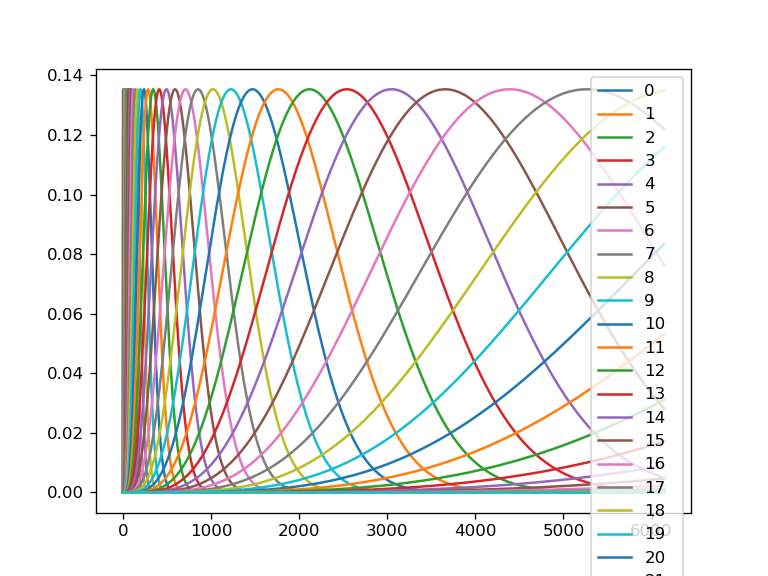

In [7]:
# if method=='needatool':
#     bl2hdu=fits.open(folder+'/0_bl2_B'+str(f'{B:.2f}')+'_Nj'+Nj+'.fits')
#     bl2=bl2hdu[1]
#     for i in np.arange(10):
#         bl2.columns[i].name='NEEDBL2_'+str(i+1)
#     bl2.columns
#     plt.figure()
#     for i in np.arange(len(bl2.columns)):
#         ax=plt.plot(bl2.data[bl2.columns[i].name], label=str(i))

if method=='alm':
    plt.figure()
    for jj in np.arange(200):
        bl=blf(np.arange(lmax+1),jj,B=B)
        plt.plot(np.arange(lmax+1),bl**2., label=jj)
    bl=blf(np.arange(lmax+1),j,B=B)
plt.legend()
#plt.semilogx()    

In [8]:
clsj=hp.sphtfunc.anafast(betas.flatten()/(sigmabeta[-1]))
lsj=np.arange(len(clsj))

In [9]:
a=6001

<IPython.core.display.Javascript object>


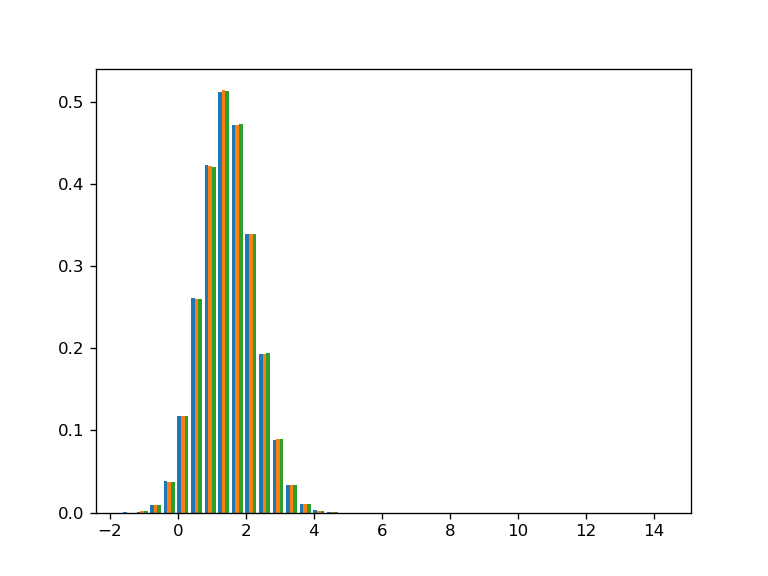

/home/javier/Programas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


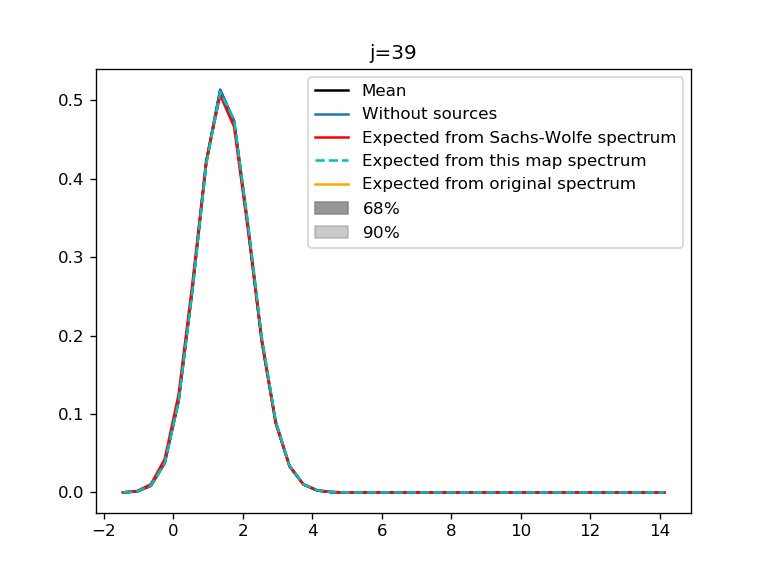

<IPython.core.display.Javascript object>


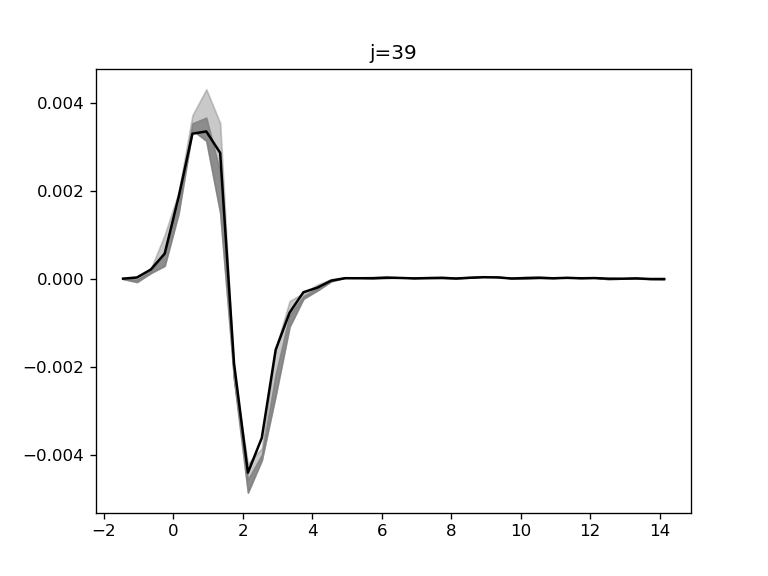

Text(0.5,1,'j=39')

In [10]:
plt.figure()
num,bins,patches=plt.hist(np.array(maxi)[:,1],bins=40,normed=1)

cbins=(bins[:-1]+bins[1:])/2

k1apro,k2apro=getks(gamma=2.5,B=B,j=j)
theo1=vfunf(cbins,k1apro,k2apro)

k1theob,k2theob=getexactks(clsj,lsj)
theo2=vfunf(cbins,k1theob,k2theob)

k1theo,k2theo=getexactks(bl[:a]**2.*gbl[:a]**2.*cls[:a]/(sigmabeta[-1]**2.*(12.*nside**2.)),ls[:a])
theo3=vfunf(cbins,k1theo,k2theo)

plt.figure()
if usesources:
    plt.plot(cbins,np.mean(num[:-1],axis=0), 'k', label='Mean')
    for perc in perclist:
        minmax=percent(perc,cbins,num[:-1])
        plt.fill_between(cbins, minmax[0],minmax[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')
    plt.plot(cbins,num[-1], label='Without sources')
else:
    plt.plot(cbins,np.mean(num,axis=0), 'k', label='Mean')
    for perc in perclist:
        minmax=percent(perc,cbins,num)
        plt.fill_between(cbins, minmax[0],minmax[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')

    
plt.plot(cbins,theo1, 'r', label='Expected from Sachs-Wolfe spectrum')
plt.plot(cbins,theo2, 'c--', label='Expected from this map spectrum',zorder=2)
plt.plot(cbins,theo3, 'orange', label='Expected from original spectrum',zorder=1)
plt.gca().set_title(f'j={int(j)}')



plt.legend()

plt.figure()
plt.plot(cbins,(np.mean(num,axis=0)-theo2), 'k', label='Mean')
for perc in perclist:
    if usesources:
        minmax2=percent(perc,cbins,num[:-1]-theo2)
    else:
        minmax2=percent(perc,cbins,num-theo2)
    plt.fill_between(cbins, minmax2[0],minmax2[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')
plt.gca().set_title(f'j={int(j)}')



<IPython.core.display.Javascript object>


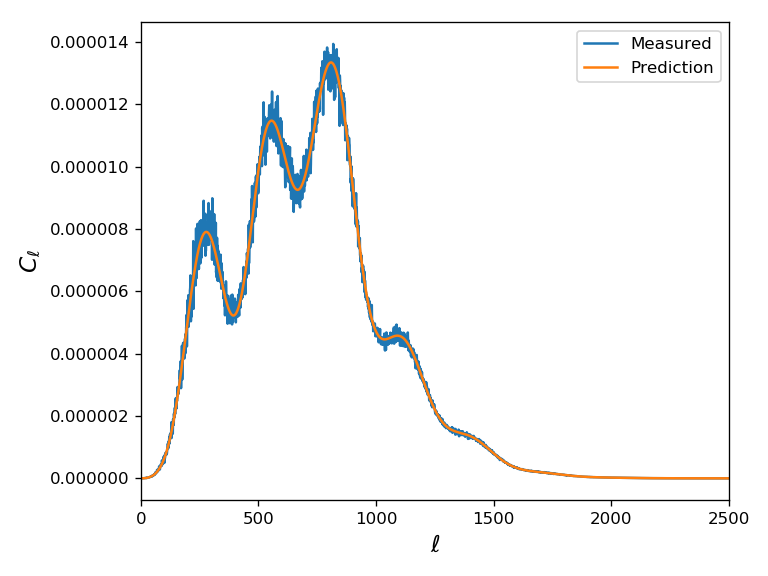

In [11]:
fig=plt.figure()
plt.plot(lsj,clsj,zorder=1, label='Measured')
plt.plot(ls[:a],bl[:a]**2.*gbl[:a]**2.*cls[:a]/(sigmabeta[-1]**2.*12.*nside**2.),zorder=2, label='Prediction')


ax=plt.gca()
ax.set_xlim([0,2500])
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel(r'$C_\ell$',fontsize=14)
plt.tight_layout()
plt.legend()


#Check that they are the same

The first 111 maxima are likely to be point sources.


<IPython.core.display.Javascript object>


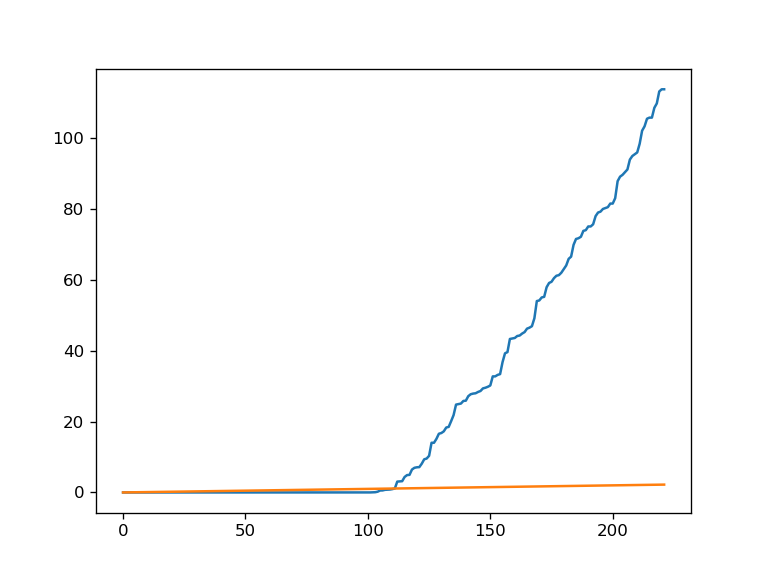

<IPython.core.display.Javascript object>


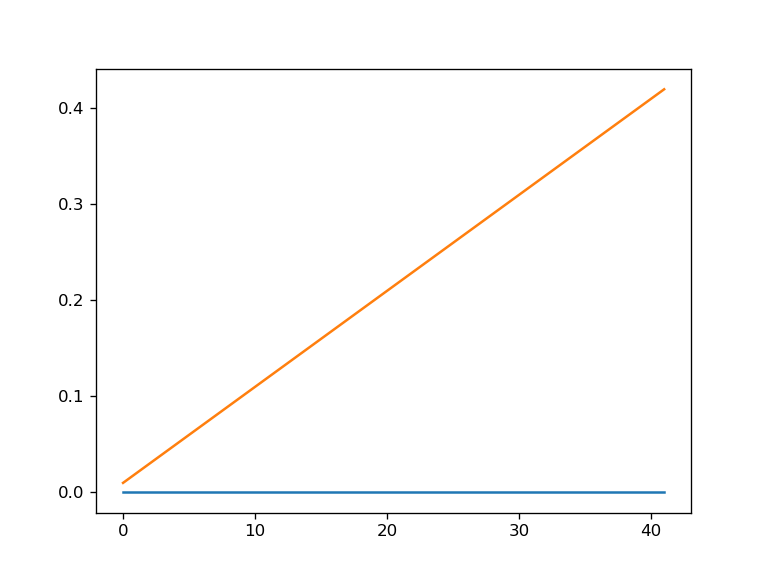

In [12]:
if usesources:
    sortmax=np.array(maxi[0])[:,maxi[0][1].argsort()]
    step=0.05
    xp=np.arange(sortmax[1,0]-step,sortmax[1,-1]+step,step)
    fp=vpval(xp,k1=k1theo,k2=k2theo)
    apvalues=np.interp(sortmax[1], xp, fp[0])

    spv=np.sort(apvalues)
    vec=np.arange(1,len(spv)+1)*alpha

    if np.shape(np.argwhere(vec>spv*len(sortmax[1])))[0] > 0:
        index=np.argwhere(vec>spv*len(sortmax[1]))[-1][0]
        print('The first '+str(index+1)+' maxima are likely to be point sources.')
        plt.figure()
        plt.plot(spv[:2*index+2]*len(sortmax[1]))
        plt.plot(vec[:2*index+2])
    else:
        print('No maxima is found to be a candidate to point source')
    indexf=20
    plt.figure()
    plt.plot(spv[:2*indexf+2]*len(sortmax[1]))
    plt.plot(vec[:2*indexf+2])


<IPython.core.display.Javascript object>


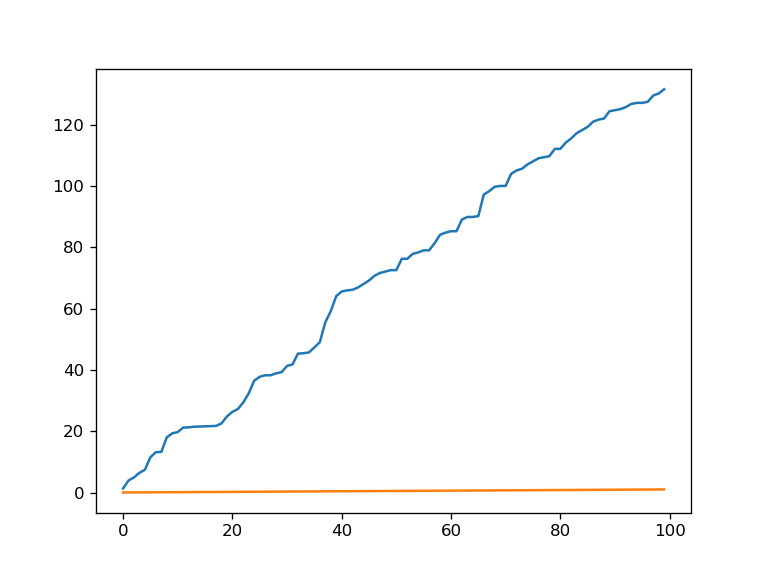

Map number 1
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.3225496558278407


<IPython.core.display.Javascript object>


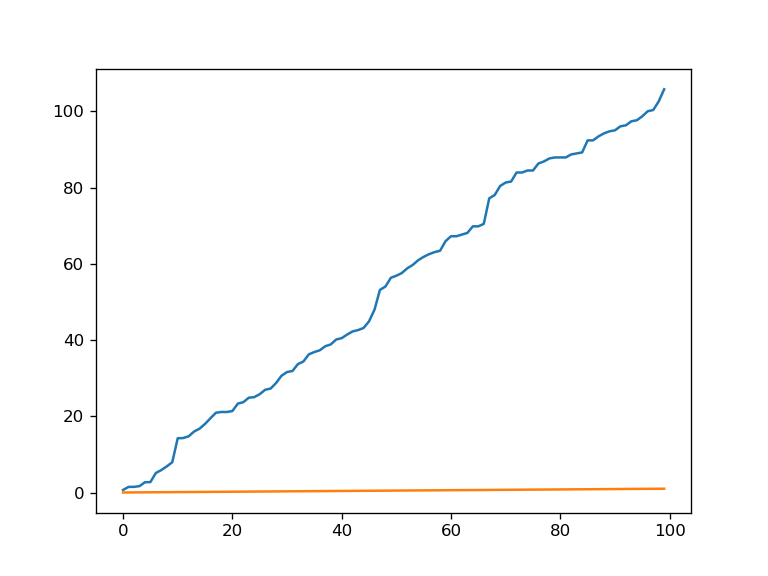

Map number 2
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.6765913965706665


<IPython.core.display.Javascript object>


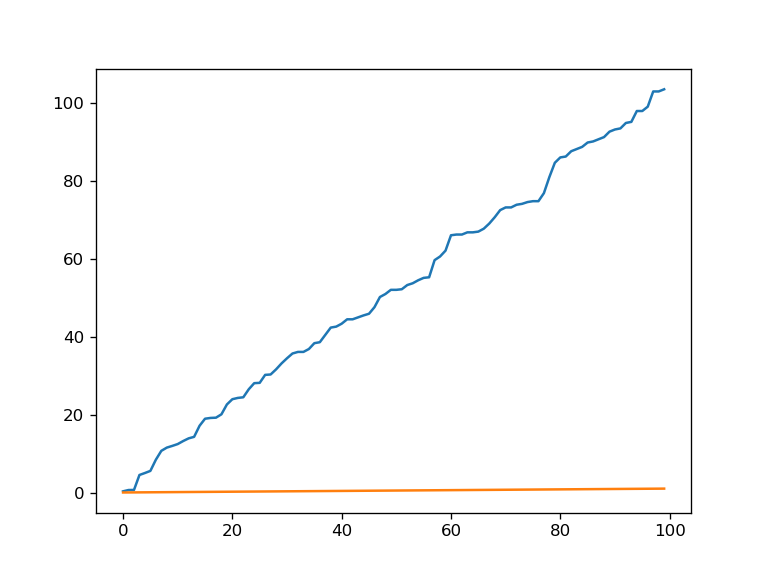

Map number 3
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.3079704962774415


<IPython.core.display.Javascript object>


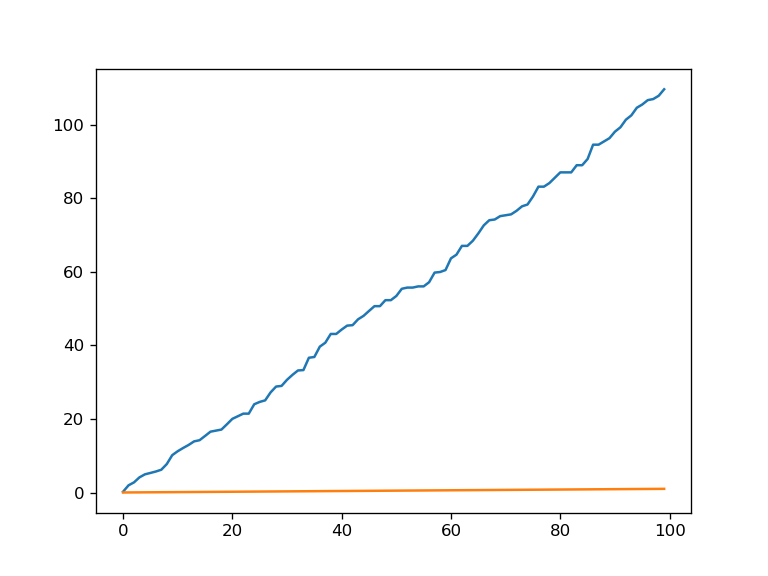

Map number 4
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.20989449091936185


<IPython.core.display.Javascript object>


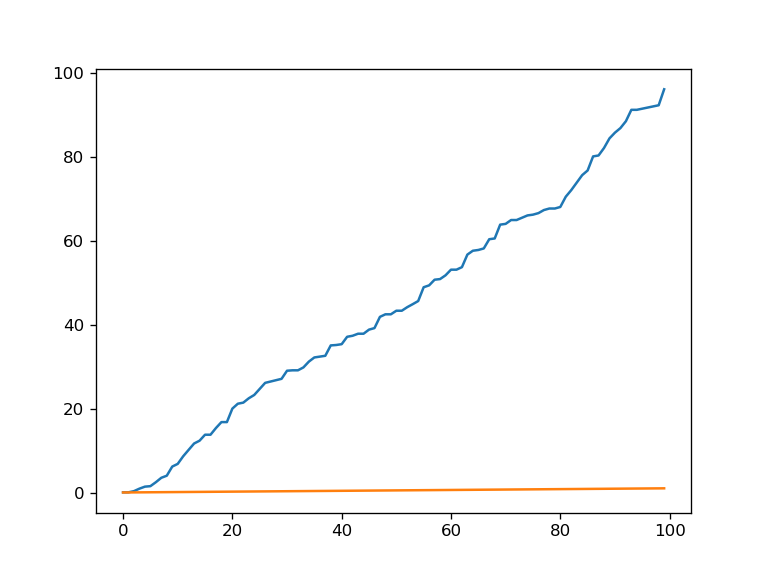

Map number 5
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.043450465007559495


<IPython.core.display.Javascript object>


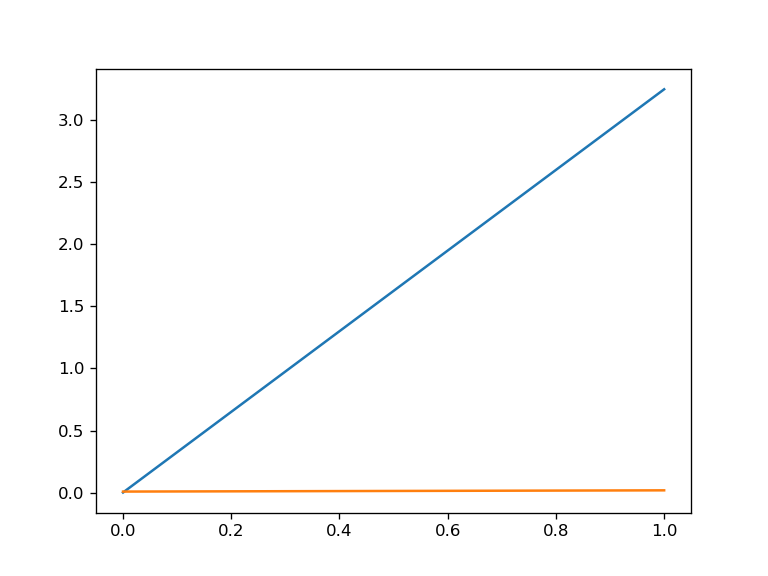

Map number 6
The first 1 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.0027447918426213506


<IPython.core.display.Javascript object>


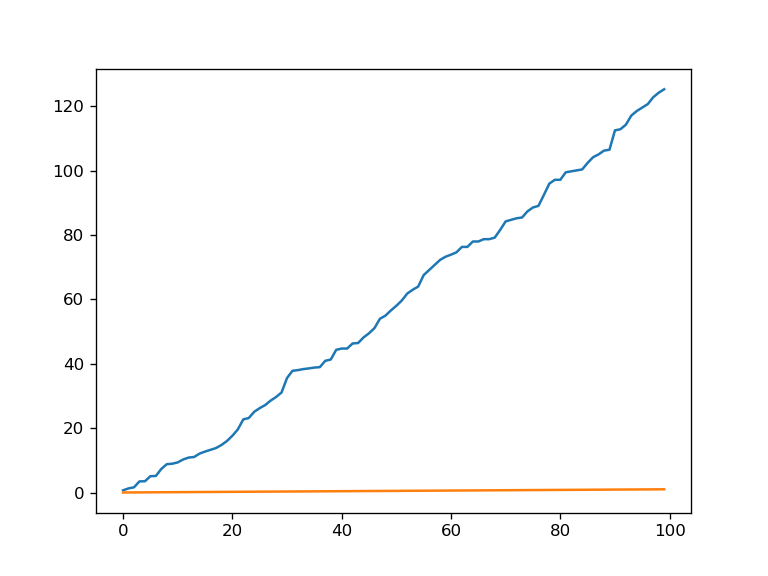

Map number 7
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.6810183522691512


<IPython.core.display.Javascript object>


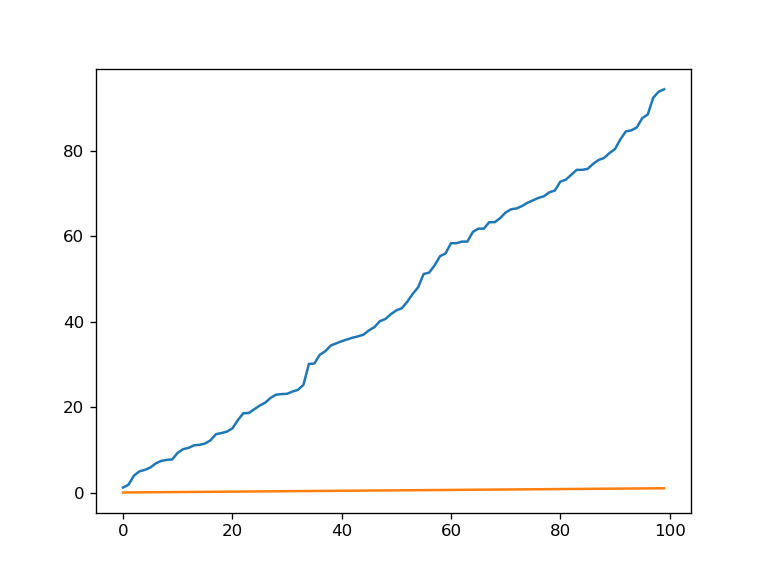

Map number 8
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.1661415987005566


<IPython.core.display.Javascript object>


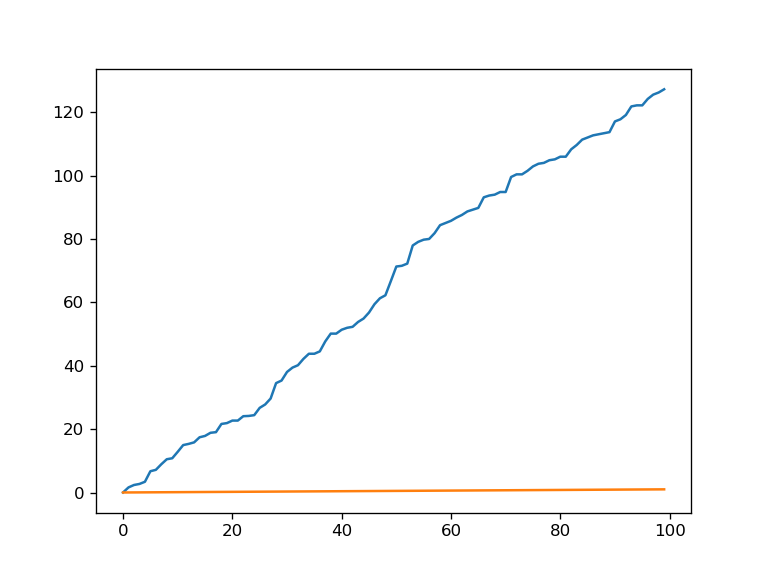

Map number 9
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.016276192067727367


<IPython.core.display.Javascript object>


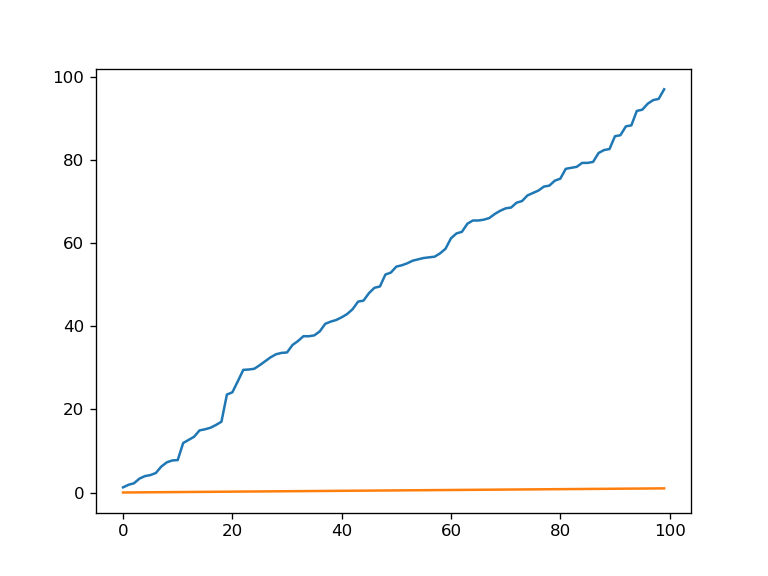

Map number 10
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.2435416572642726


<IPython.core.display.Javascript object>


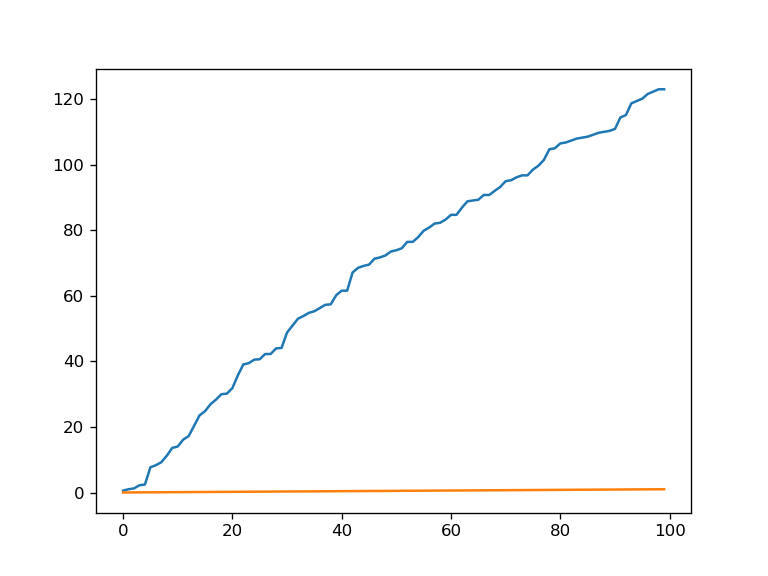

Map number 11
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.5557863988062225


<IPython.core.display.Javascript object>


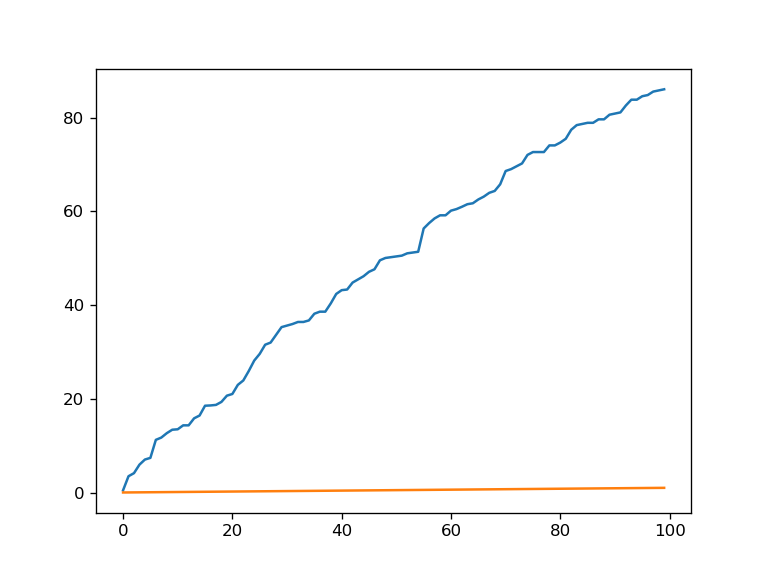

Map number 12
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.4680598630709556


<IPython.core.display.Javascript object>


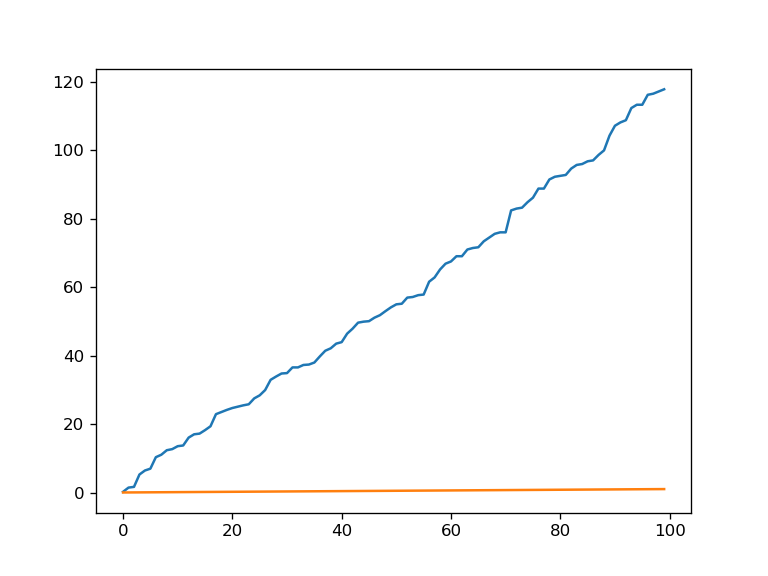

Map number 13
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.20261436649726589


<IPython.core.display.Javascript object>


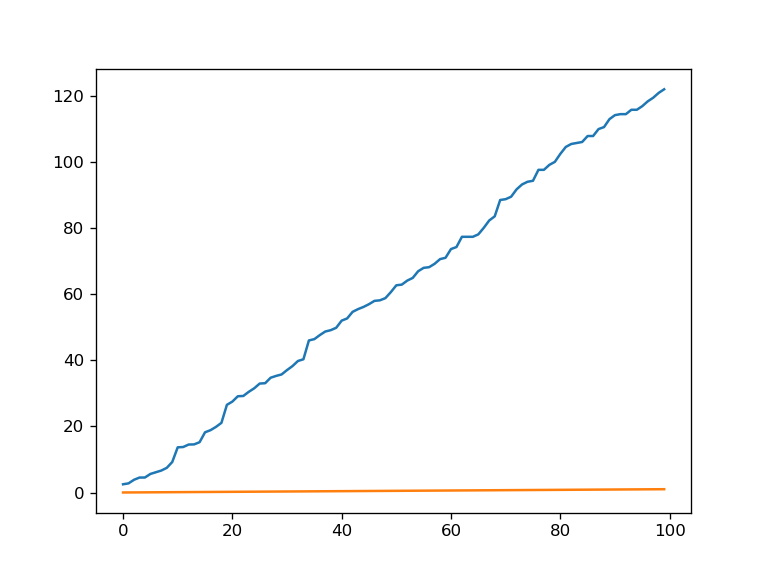

Map number 14
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.4927927452503766


<IPython.core.display.Javascript object>


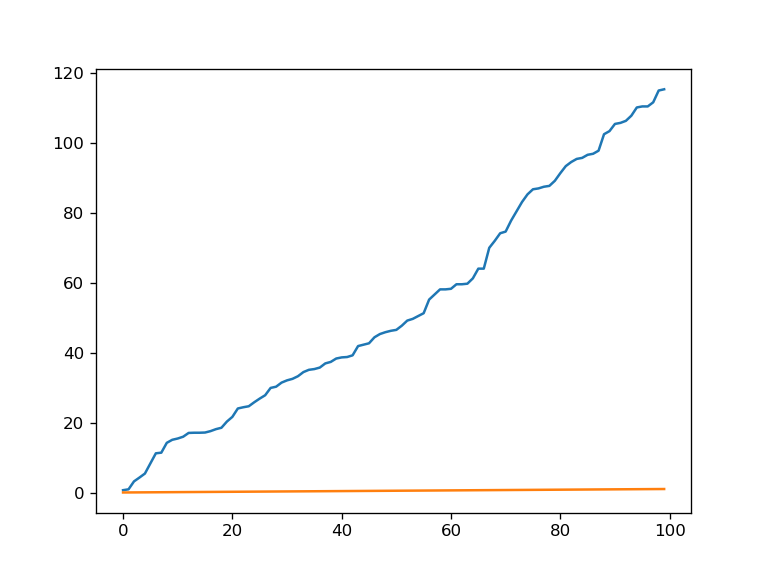

Map number 15
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.6681125319822333


/home/javier/Programas/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


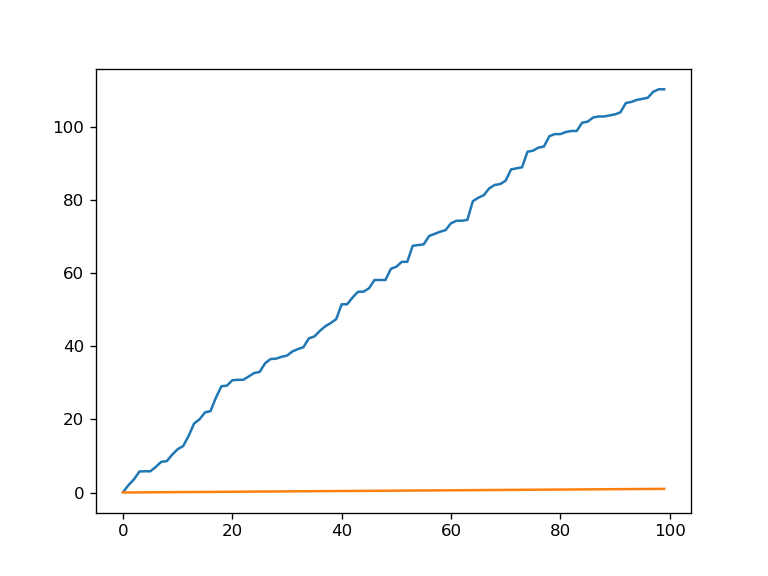

Map number 16
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.10339956850569228


<IPython.core.display.Javascript object>


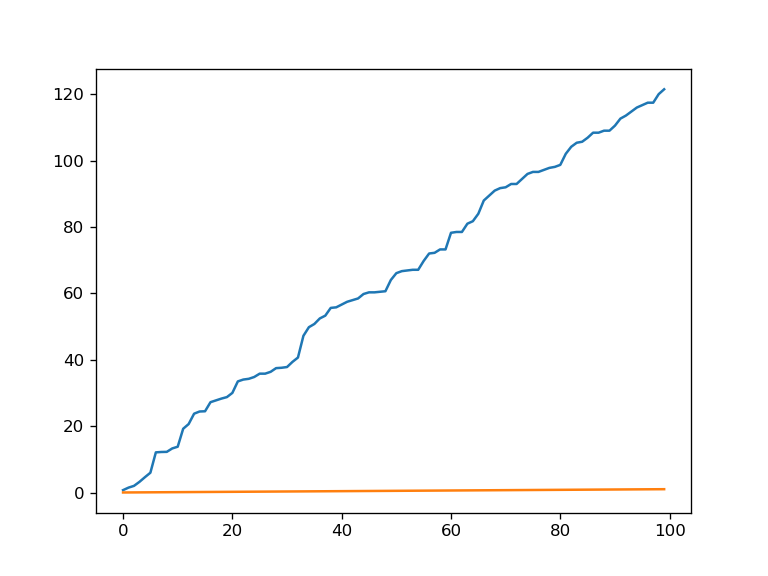

Map number 17
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.719218890157538


<IPython.core.display.Javascript object>


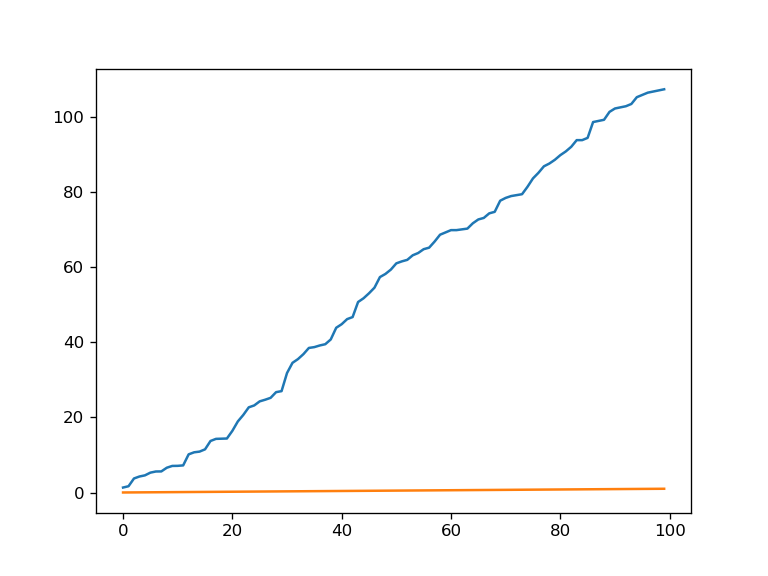

Map number 18
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.3267268501400846


<IPython.core.display.Javascript object>


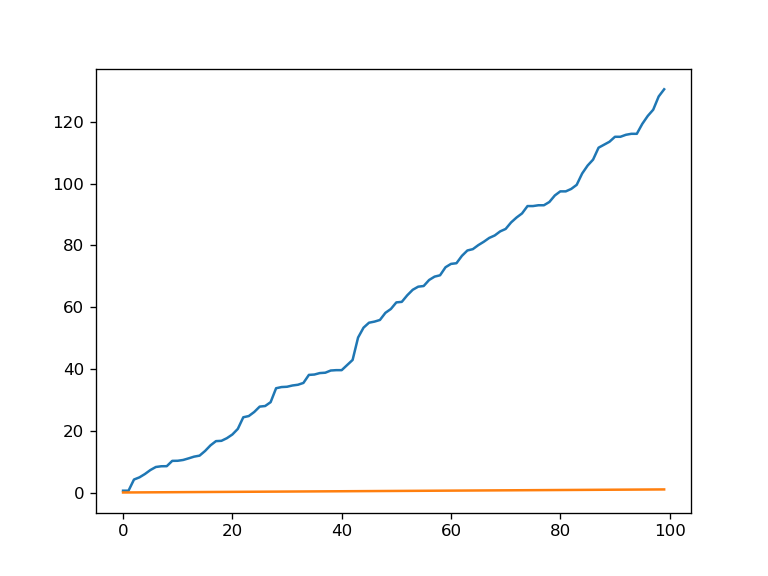

Map number 19
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.5869797616730331


<IPython.core.display.Javascript object>


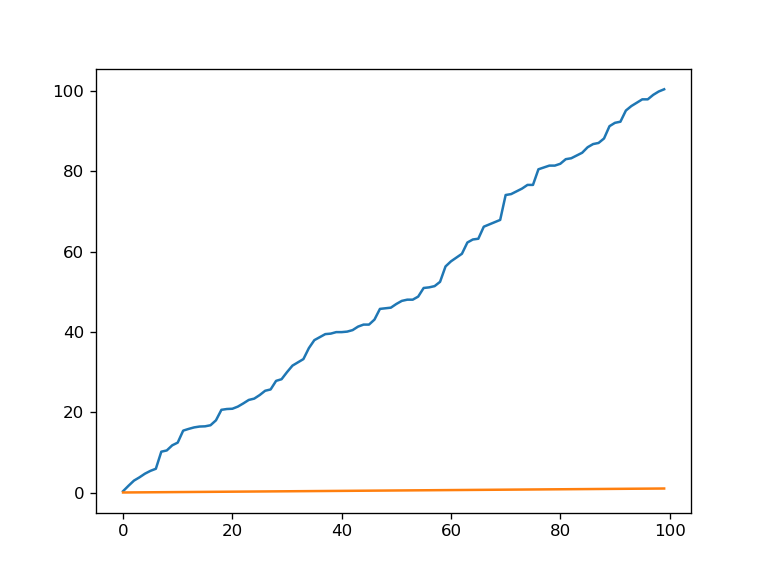

Map number 20
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.32499552007597554


<IPython.core.display.Javascript object>


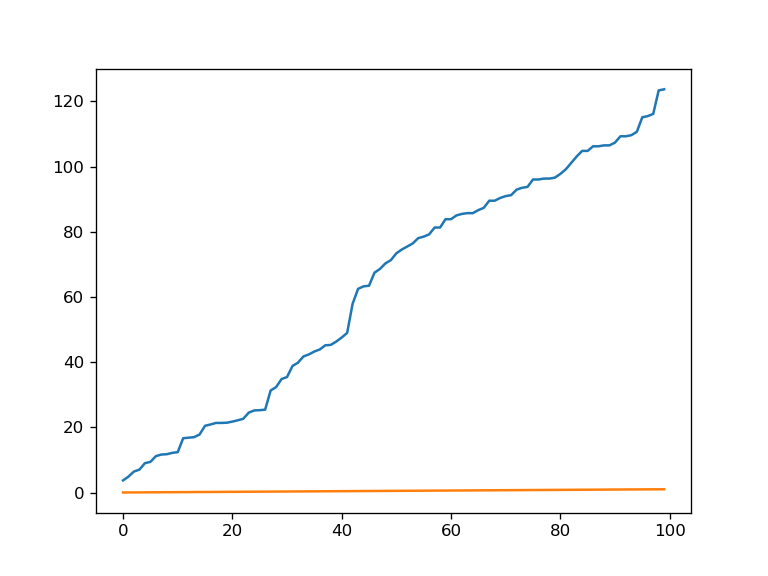

Map number 21
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 3.719276829304232


<IPython.core.display.Javascript object>


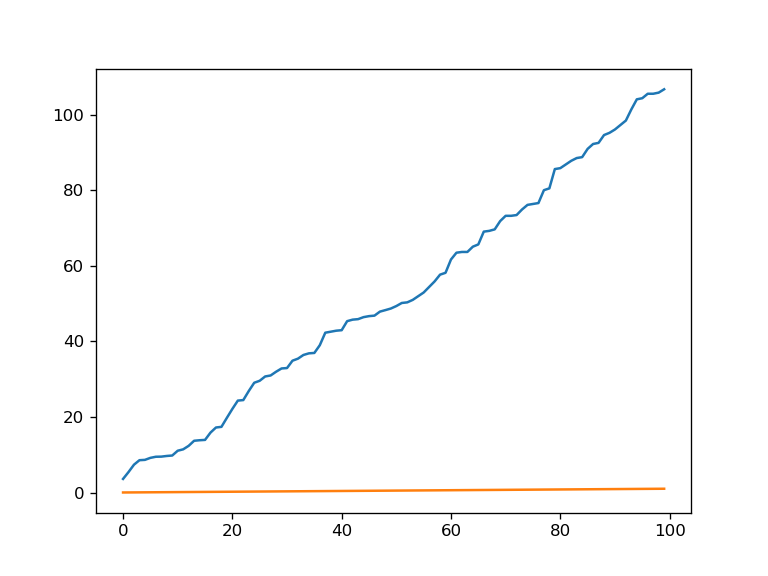

Map number 22
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 3.5971106917348155


<IPython.core.display.Javascript object>


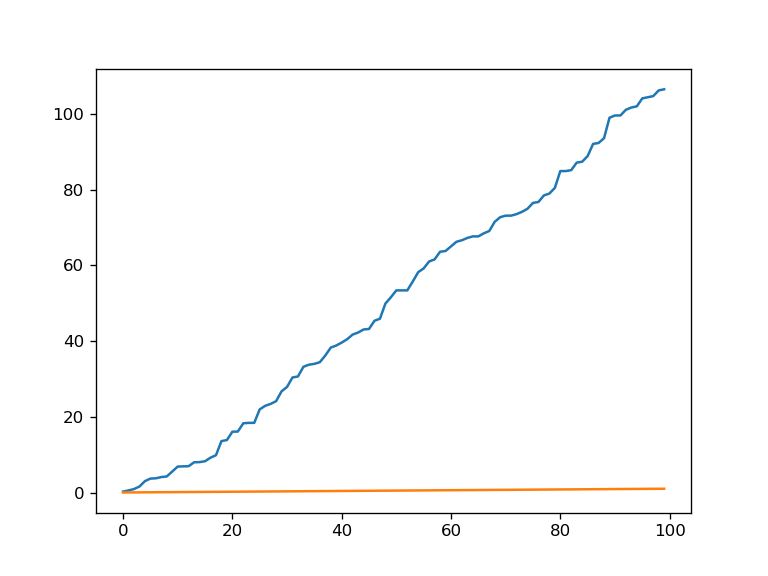

Map number 23
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.23808456229901


<IPython.core.display.Javascript object>


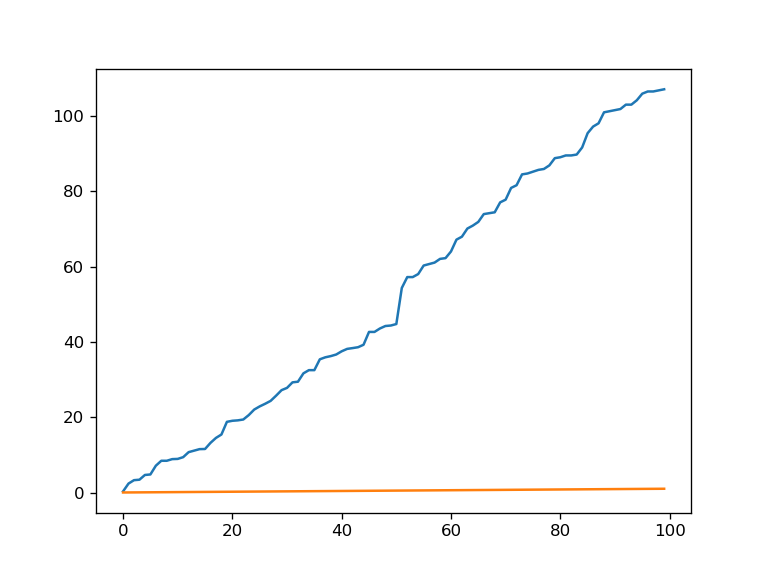

Map number 24
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.2937729179236507


<IPython.core.display.Javascript object>


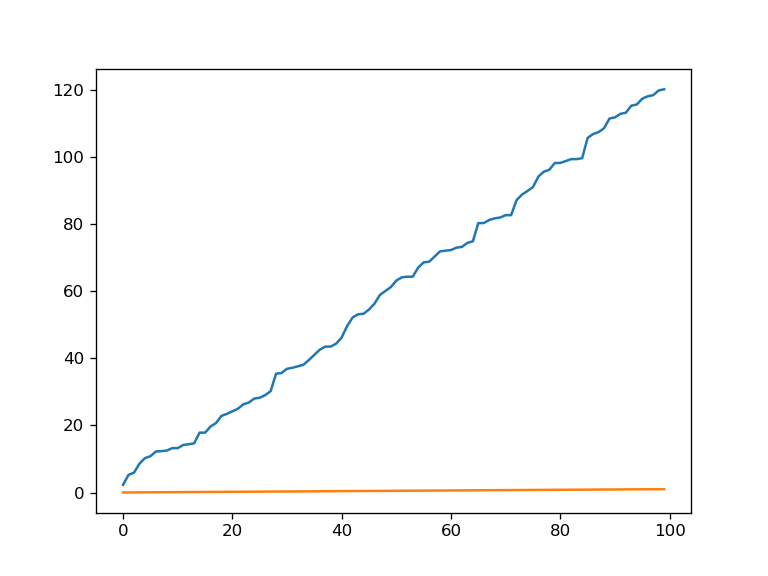

Map number 25
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.2976469546179517


<IPython.core.display.Javascript object>


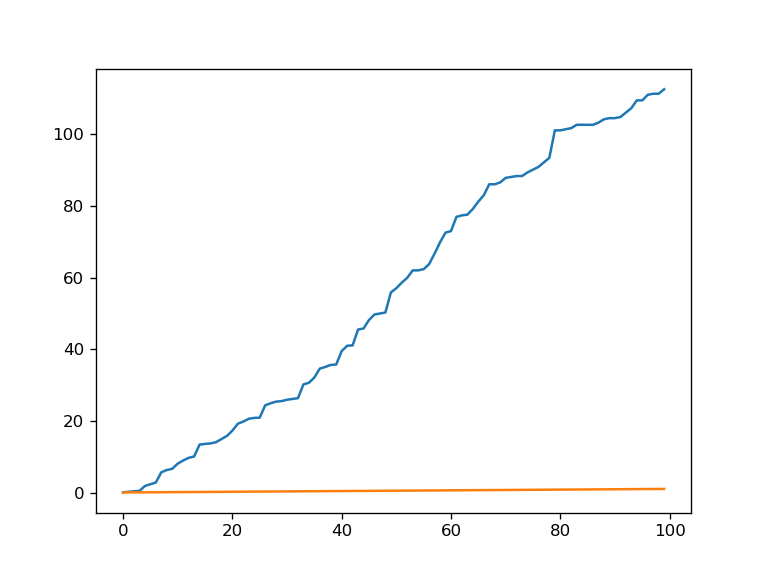

Map number 26
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.06412308482494893


<IPython.core.display.Javascript object>


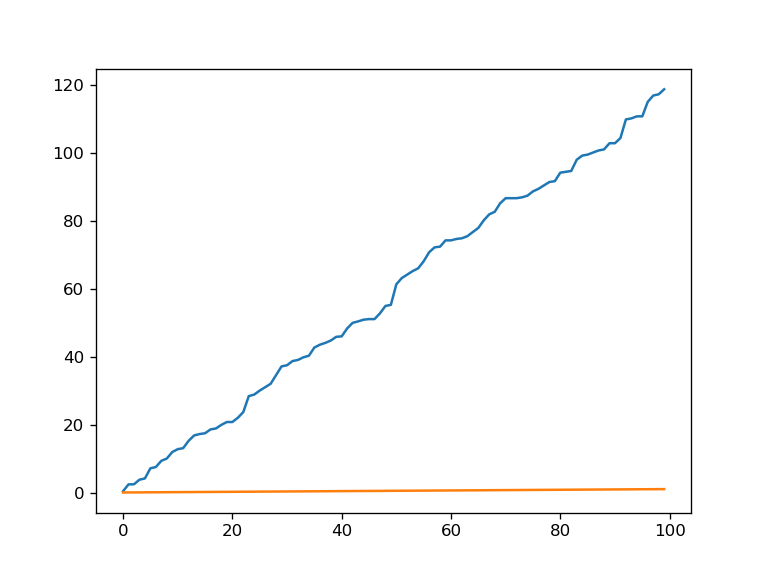

Map number 27
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.3864294189806719


<IPython.core.display.Javascript object>


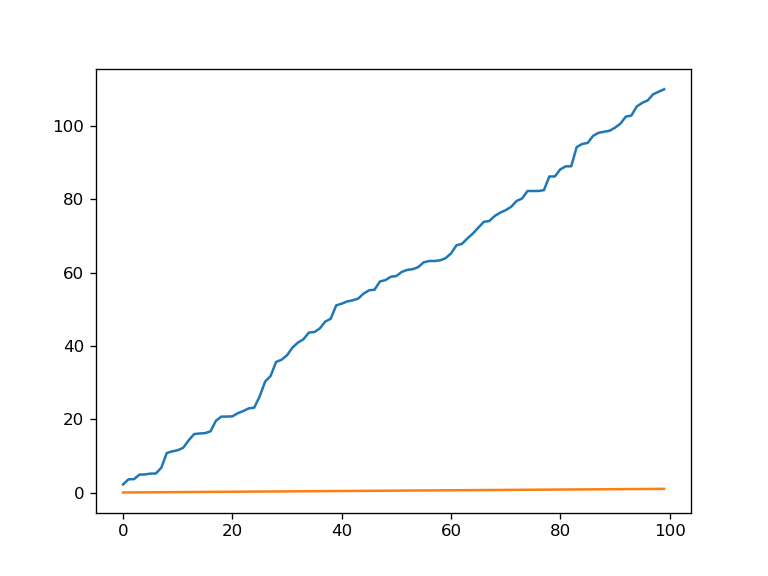

Map number 28
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.1992252748731826


<IPython.core.display.Javascript object>


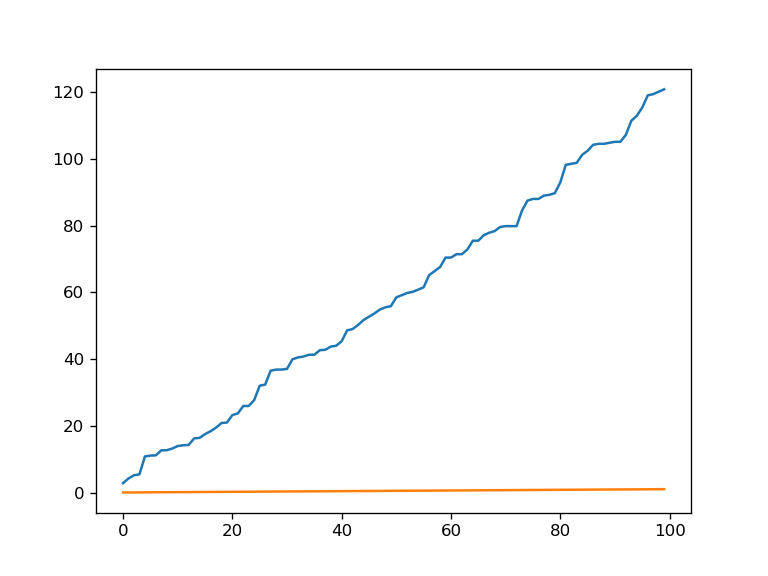

Map number 29
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.8131250690869347


<IPython.core.display.Javascript object>


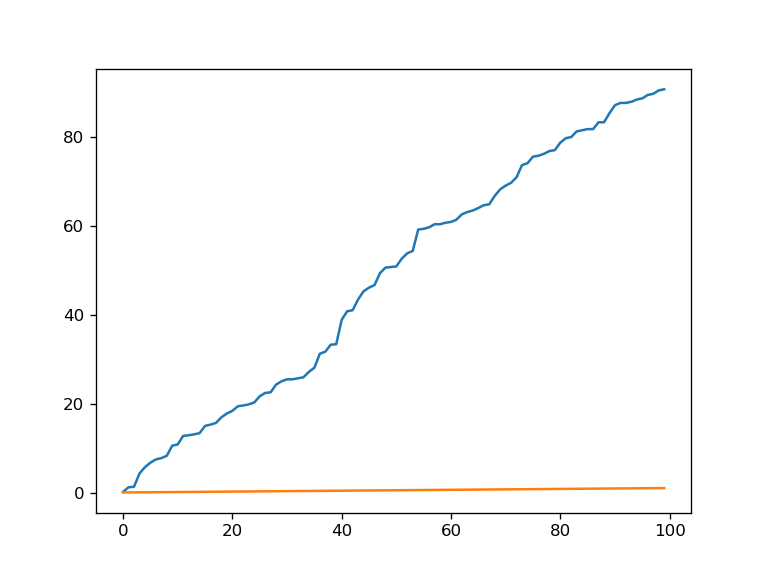

Map number 30
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.15229279492807718


<IPython.core.display.Javascript object>


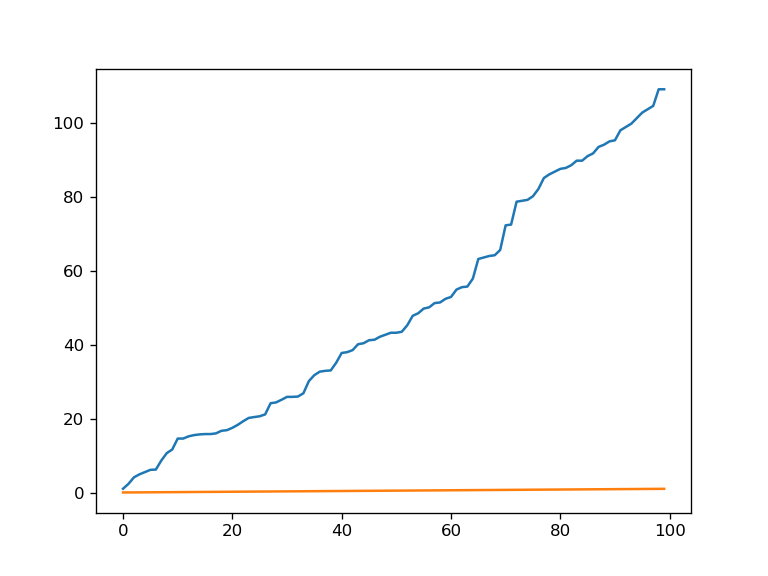

Map number 31
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.0243638477405672


<IPython.core.display.Javascript object>


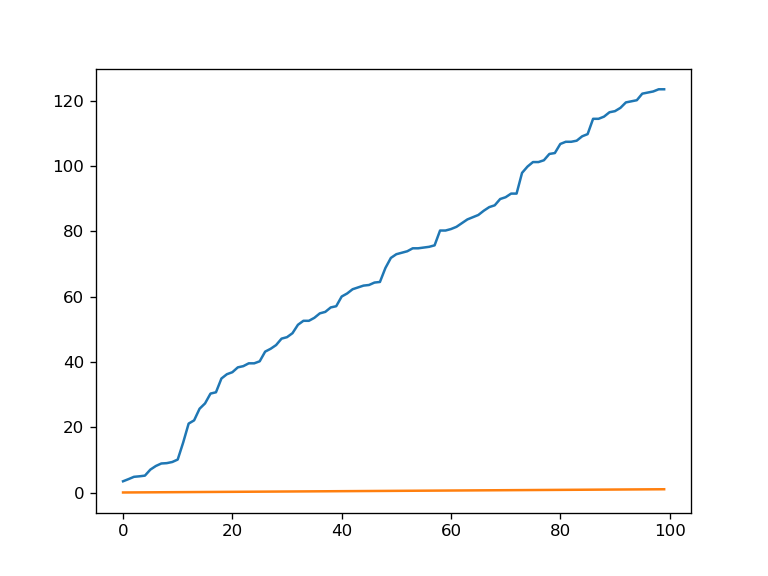

Map number 32
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 3.4412928941693846


<IPython.core.display.Javascript object>


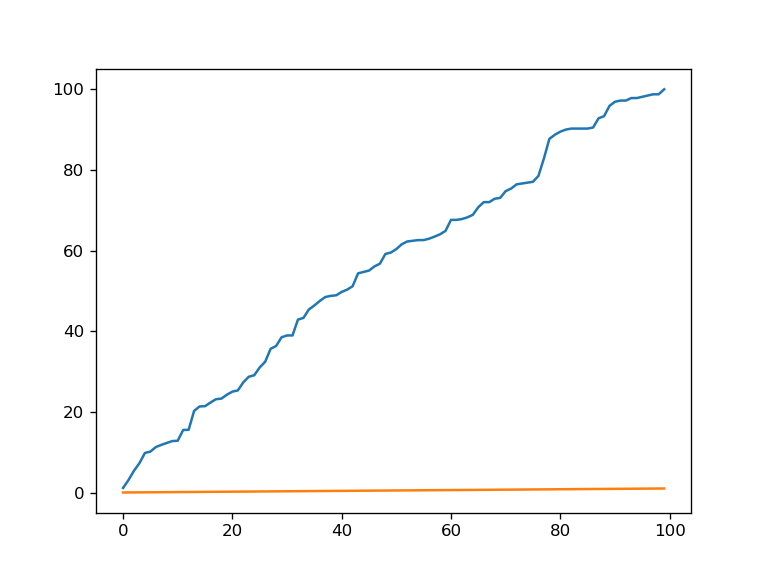

Map number 33
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.1336554416013047


<IPython.core.display.Javascript object>


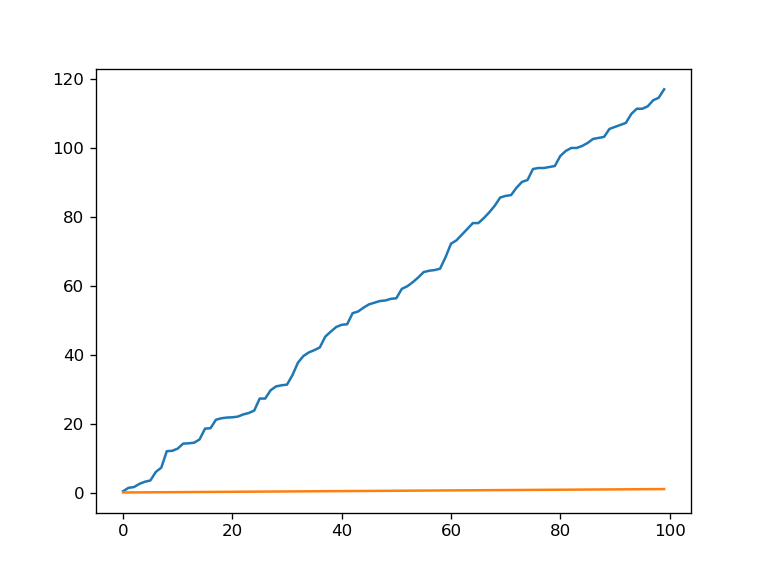

Map number 34
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.36400069660242296


<IPython.core.display.Javascript object>


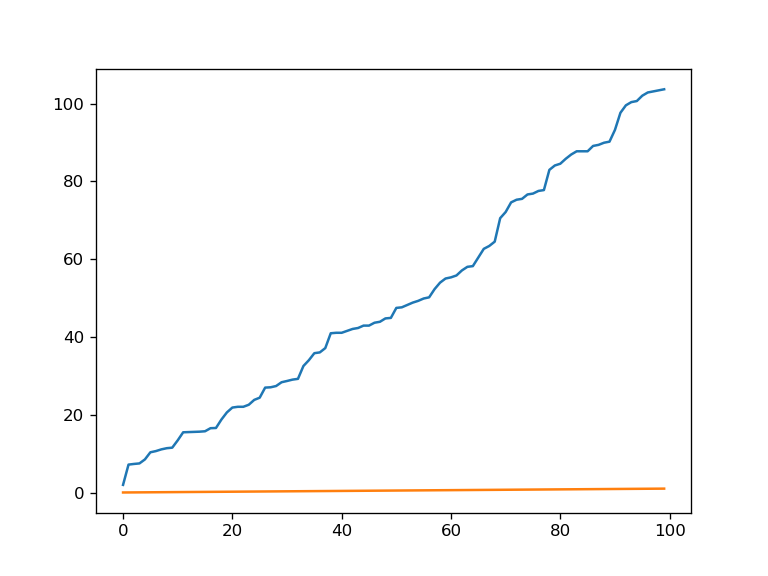

Map number 35
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.968575572080742


<IPython.core.display.Javascript object>


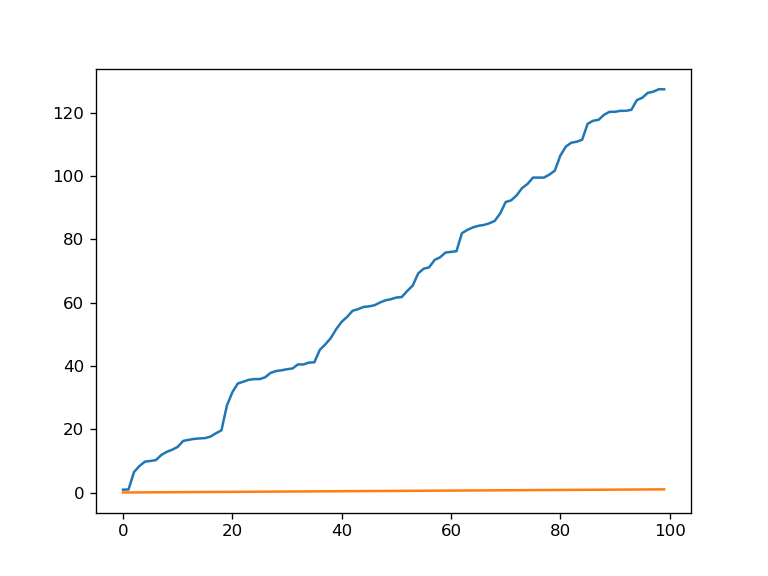

Map number 36
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.9021105455643531


<IPython.core.display.Javascript object>


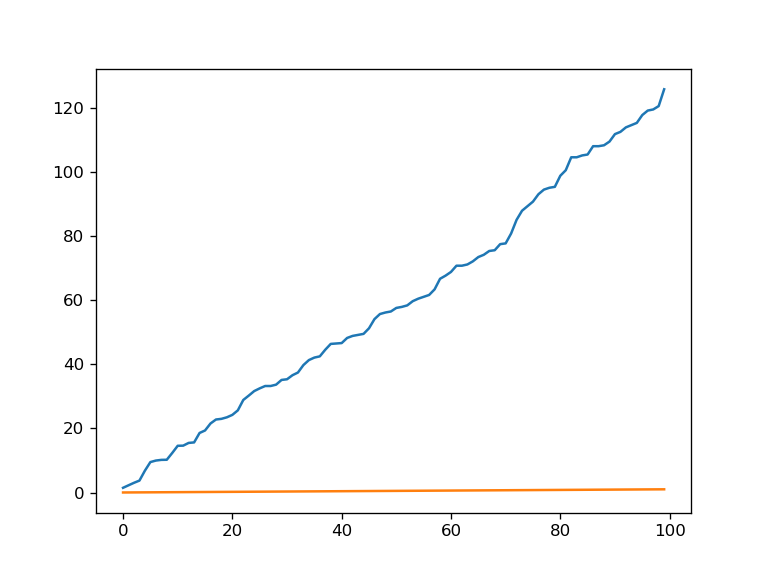

Map number 37
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.4711904379334495


<IPython.core.display.Javascript object>


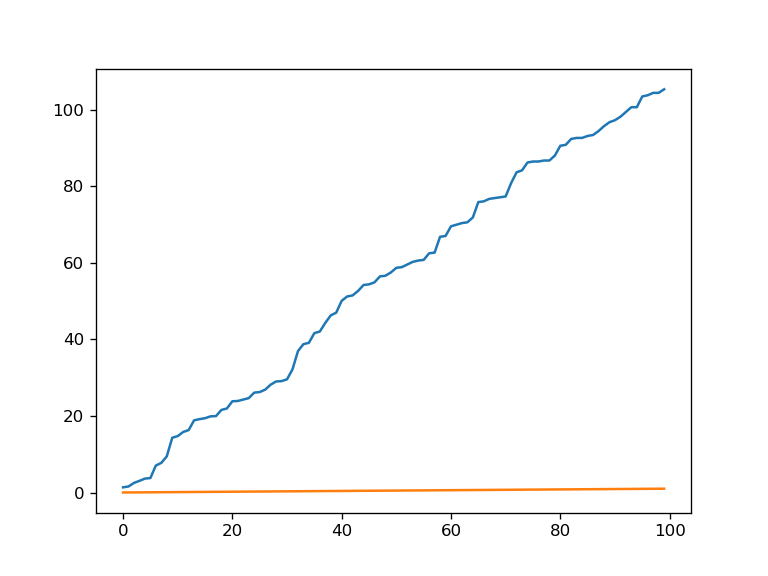

Map number 38
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.3532196611331118


<IPython.core.display.Javascript object>


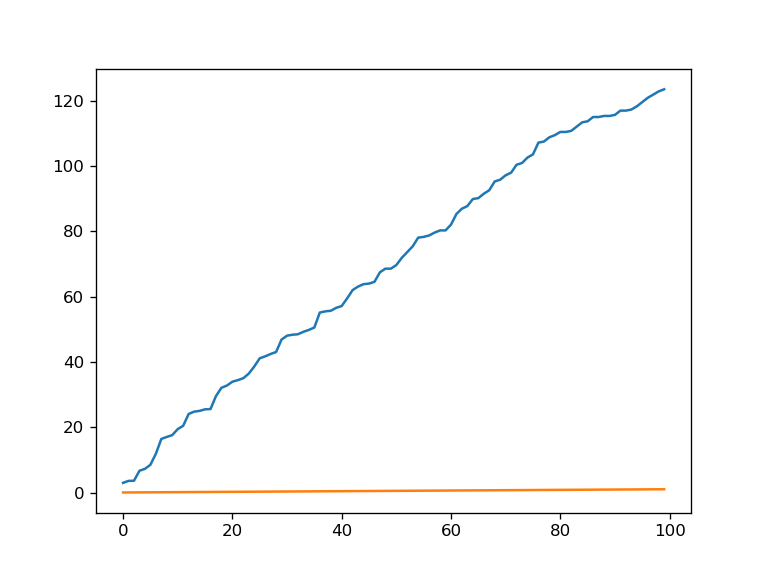

Map number 39
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.9576623881742594


<IPython.core.display.Javascript object>


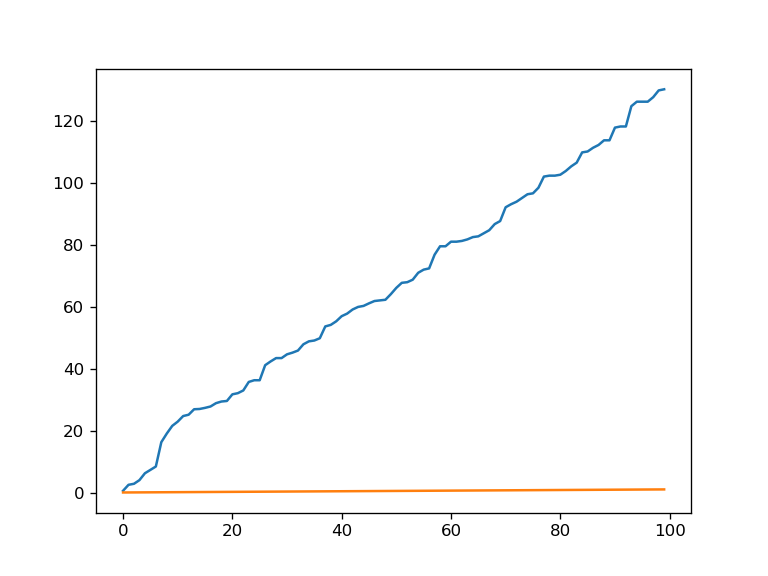

Map number 40
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.5555220047477925


<IPython.core.display.Javascript object>


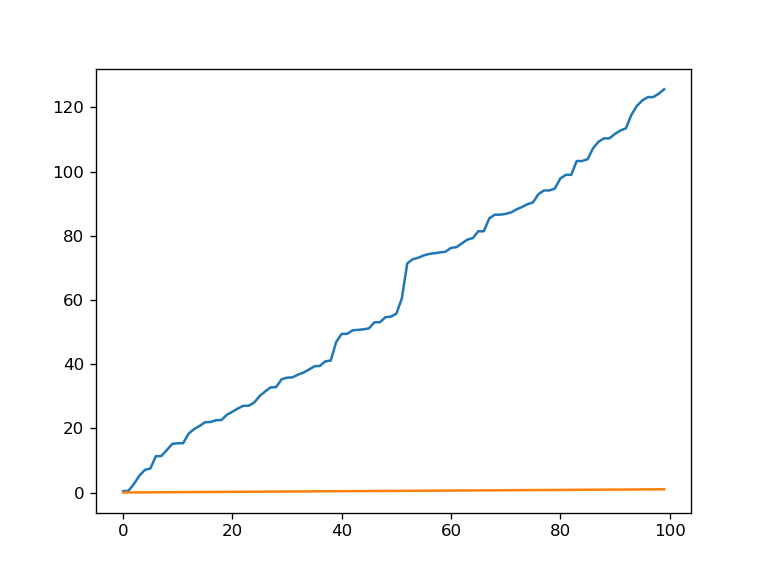

Map number 41
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.4160168599274743


<IPython.core.display.Javascript object>


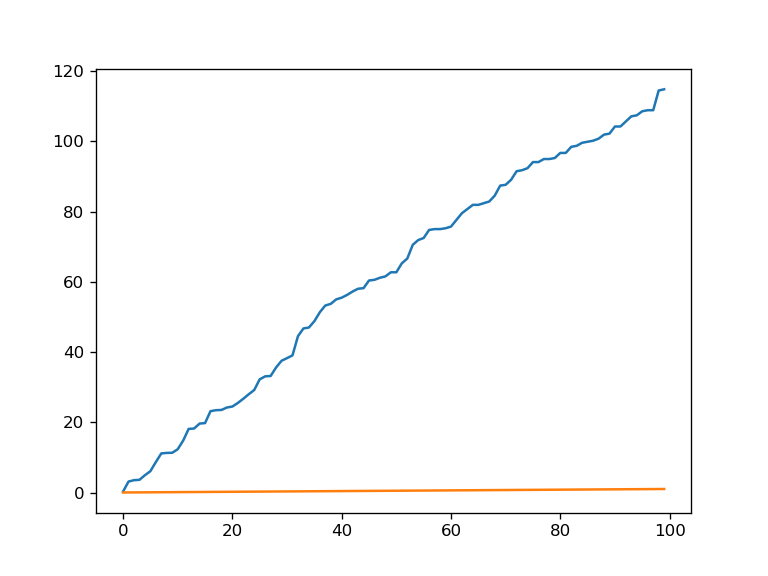

Map number 42
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.26770346775843806


<IPython.core.display.Javascript object>


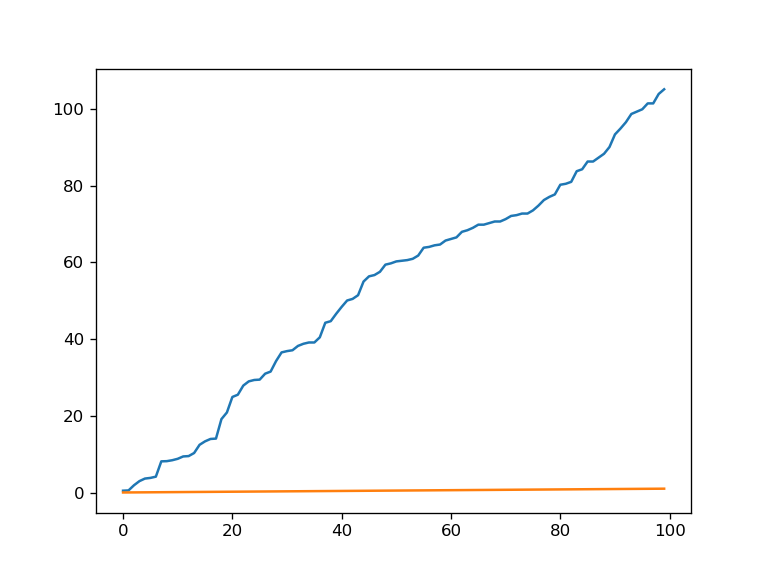

Map number 43
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.47551450849617233


<IPython.core.display.Javascript object>


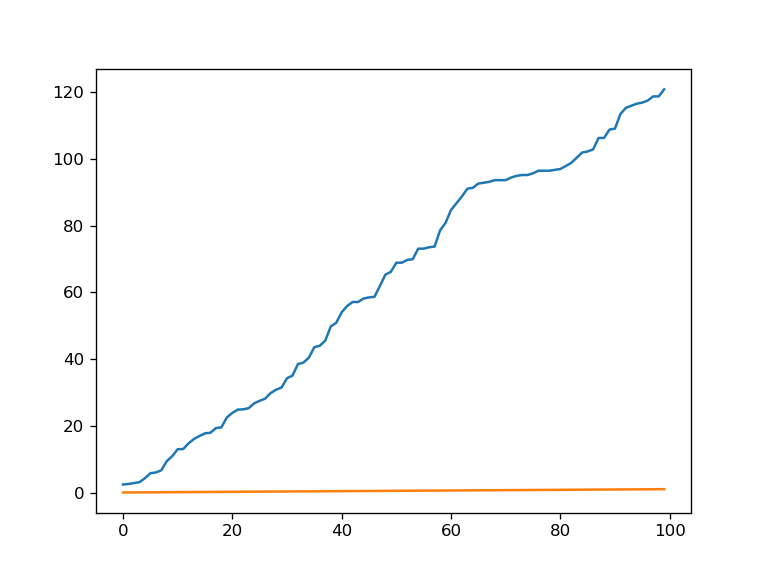

Map number 44
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.3998886169597484


<IPython.core.display.Javascript object>


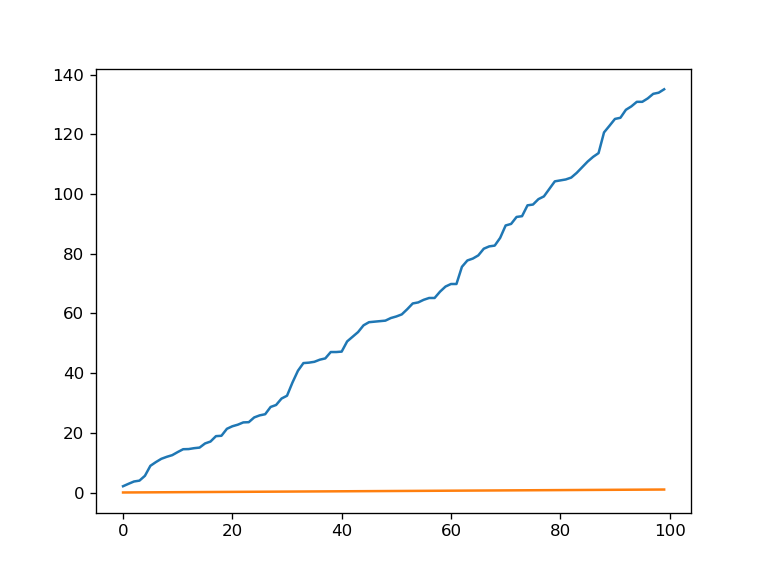

Map number 45
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 2.1042141649723116


<IPython.core.display.Javascript object>


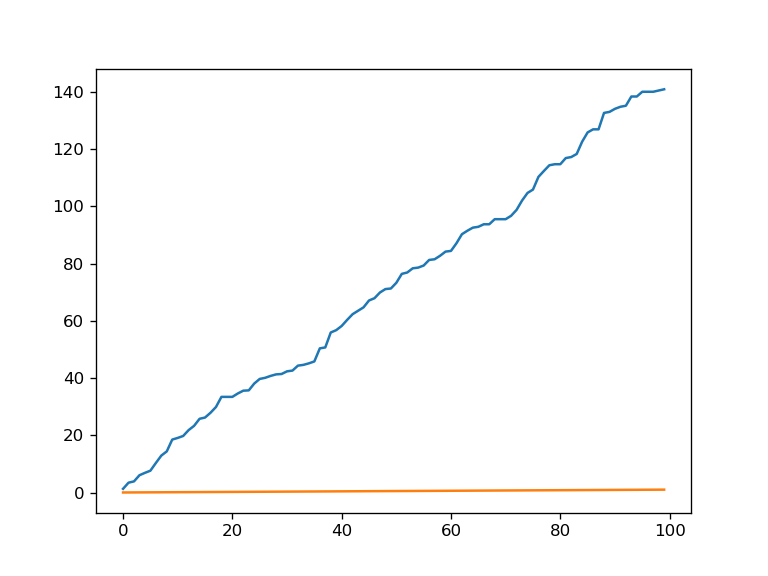

Map number 46
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 1.289110223245501


<IPython.core.display.Javascript object>


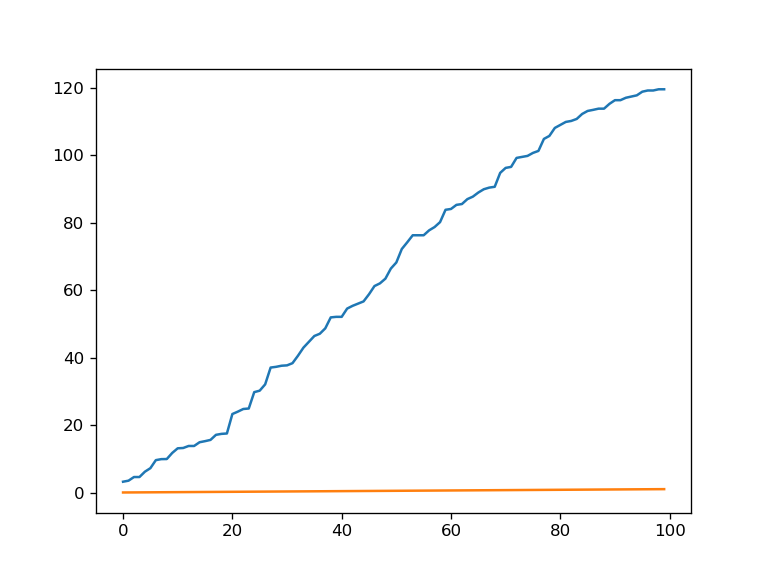

Map number 47
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 3.2051673226292485


<IPython.core.display.Javascript object>


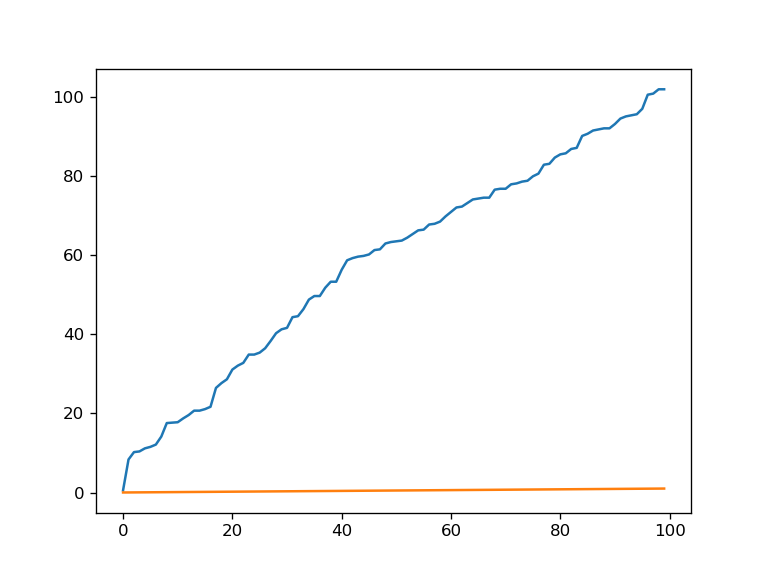

Map number 48
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.5484901992726011


<IPython.core.display.Javascript object>


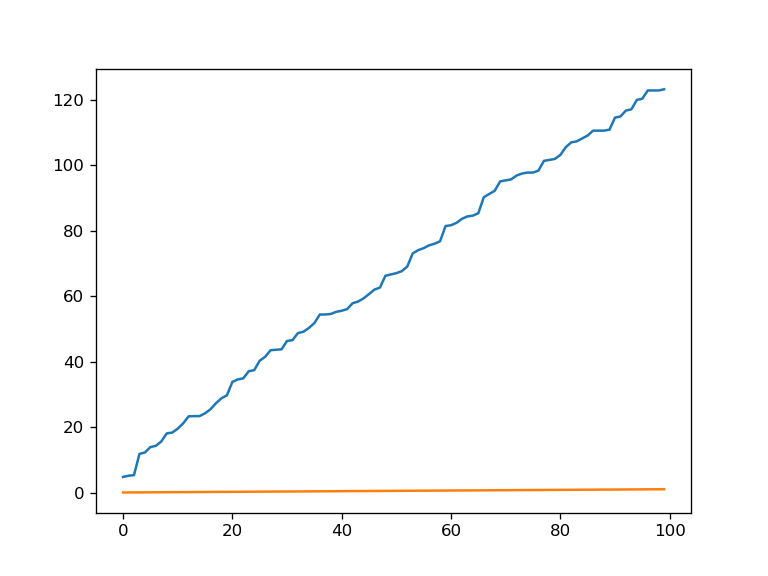

Map number 49
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 4.756159504947246


<IPython.core.display.Javascript object>


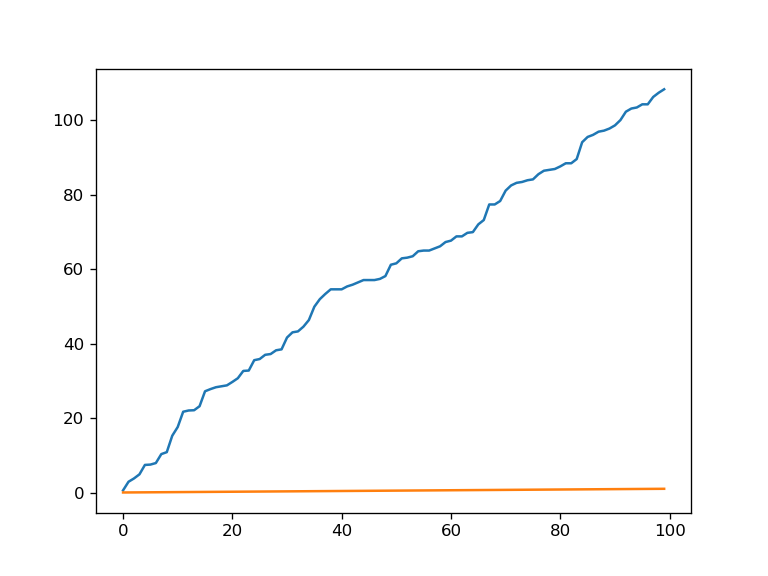

Map number 50
The first 0 maxima are likely to be point sources.
To the first maximum, alpha would need to be larger than 0.5799674358889955


The average of detected maxima is 0.02 +- 0.13999999999999999 in 50 maps
A total of 1 maps present a total of 1 candidates


In [13]:
nfalsedetect=[]
canmap=0
cannum=0
if not usesources:
    for imap in np.arange(nmaps):
        sortmax=np.array(maxi[imap])[:,maxi[imap][1].argsort()]
        step=0.05
        xp=np.arange(sortmax[1,0]-step,sortmax[1,-1]+step,step)
        fp=vpval(xp,k1=k1theo,k2=k2theo)
        apvalues=np.interp(sortmax[1], xp, fp[0])

        spv=np.sort(apvalues)
        vec=np.arange(1,len(spv)+1)*alpha

        if np.shape(np.argwhere(vec>spv*len(sortmax[1])))[0] > 0:
            index=np.argwhere(vec>spv*len(sortmax[1]))[-1][0]+1
            plt.figure()
            plt.plot(spv[:2*index]*len(sortmax[1]))
            plt.plot(vec[:2*index])
            canmap=canmap+1
            cannum=cannum+index
        else:
            index=0
            plt.figure()
            plt.plot(spv[:100]*len(sortmax[1]))
            plt.plot(vec[:100])
        nfalsedetect.append(index)

        print(f'Map number {imap+1}')
        print('The first '+str(index)+' maxima are likely to be point sources.')
        print('To the first maximum, alpha would need to be larger than '+str(spv[0]*len(sortmax[1])))
    print('\n')
    print(f'The average of detected maxima is {np.mean(nfalsedetect)} +- {np.std(nfalsedetect)} in {nmaps} maps')
    print(f'A total of {canmap} maps present a total of {cannum} candidates')

<IPython.core.display.Javascript object>


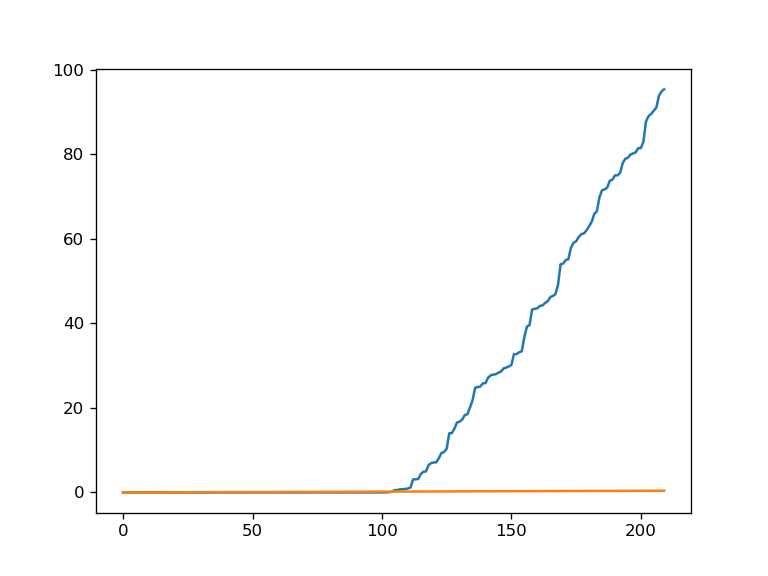

Map number 1
The first 104 maxima are likely to be point sources.
104 out of the 104 candidates are closer than 0.0029980274646869785 radians from an injected signal (100.0%)
105 out of the 200 injected signals are closer than 0.0029980274646869785 radians from a candidate (52.5%)
0.0029980274646869785 radians is 10.306459235452218 arcmins




<IPython.core.display.Javascript object>


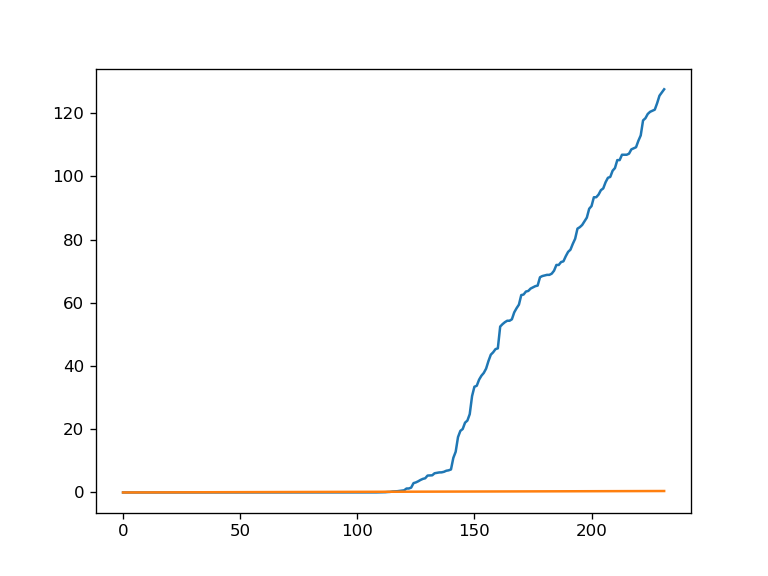

Map number 2
The first 115 maxima are likely to be point sources.
114 out of the 115 candidates are closer than 0.0029980274646869785 radians from an injected signal (99.1304347826087%)
115 out of the 200 injected signals are closer than 0.0029980274646869785 radians from a candidate (57.49999999999999%)
0.0029980274646869785 radians is 10.306459235452218 arcmins


In the map without injected signals, 1 maxima are likely to be point sources


The maximum fraction of the sky covered by the tolerance region is 0.04494084339508716%


On average, the power of detection is (55.00000000000001 +- 2.4999999999999964)% and the fdp is (99.56521739130434 +- 0.43478260869564966)%.


In [13]:
if usesources:
    detect=[]
    detectinten=[]
    detectintenpost=[]
    falsedetmap=[]
    truebeta=[]
    falsebeta=[]
    
    souintenpost=sources[pixsou]
    power=np.zeros(nmaps)
    fdp=np.zeros(nmaps)
    for imap in np.arange(nmaps+1):
        sortmax=np.array(maxi[imap])[:,maxi[imap][1].argsort()]
        step=0.05
        xp=np.arange(sortmax[1,0]-step,sortmax[1,-1]+step,step)
        fp=vpval(xp,k1=k1theob,k2=k2theob)
        apvalues=np.interp(sortmax[1], xp, fp[0])

        spv=np.sort(apvalues)
        alpha=0.002
        vec=np.arange(1,len(spv)+1)*alpha

        if np.shape(np.argwhere(vec>spv*len(sortmax[1])))[0] > 0:
            index=np.argwhere(vec>spv*len(sortmax[1]))[-1][0]+1
            plt.figure()
            plt.plot(spv[:2*index+2]*len(sortmax[1]))
            plt.plot(vec[:2*index+2])
        else:
            index=0
            #plt.figure()
            #plt.plot(spv[:100]*len(sortmax[1]))
            #plt.plot(vec[:100])


        if imap < nmaps:

            print(f'Map number {imap+1}')
            print('The first '+str(index)+' maxima are likely to be point sources.')
            if index>0:
                canlist=sortmax[0,-index:]
                intlist=sortmax[1,-index:]
                distances=scipy.spatial.distance.cdist(vecsou,np.array(hp.pix2vec(nsidebeta,canlist.astype(int))).T,'cosine')
                where=np.argwhere(np.abs(distances)<1.-np.cos(angtol))
                
                falsedet=canlist[np.delete(np.arange(index),np.unique(where[:,1]))]
                detect.append(np.unique(where[:,0]))
                detectinten.append(souinten[detect[imap]])
                detectintenpost.append(souintenpost[detect[imap]])
                falsedetmap.append(mapa[falsedet.astype(int)])
                falsebeta.append(intlist[np.delete(np.arange(index),np.unique(where[:,1]))])
                truebeta.append(intlist[np.unique(where[:,1])])

                power[imap]=detect[imap].shape[0]/nsources
                fdp[imap]=np.unique(where[:,1]).shape[0]/canlist.shape[0]

                print(f'{np.unique(where[:,1]).shape[0]} out of the {canlist.shape[0]} candidates are closer than {angtol} radians from an injected signal ({fdp[imap]*100}%)')
                print(f'{np.unique(where[:,0]).shape[0]} out of the {nsources} injected signals are closer than {angtol} radians from a candidate ({power[imap]*100}%)')
                print(f'{angtol} radians is {angtol*360.*60./(2.*np.pi)} arcmins')
            else:
                detect.append(np.array([]))
                detectinten.append(np.array([]))
                detectintenpost.append(np.array([]))
                falsedetmap.append(np.array([]))
                falsebeta.append(np.array([]))
                truebeta.append(np.array([]))
            print('\n')

    print(f'In the map without injected signals, {index+1} maxima are likely to be point sources')
    print('\n')
    print(f'The maximum fraction of the sky covered by the tolerance region is {(angtol)**2.*nsources*100./4.}%')
    print('\n')
    print(f'On average, the power of detection is ({power.mean()*100} +- {power.std()*100})% and the fdp is ({fdp.mean()*100} +- {fdp.std()*100})%.')


<IPython.core.display.Javascript object>


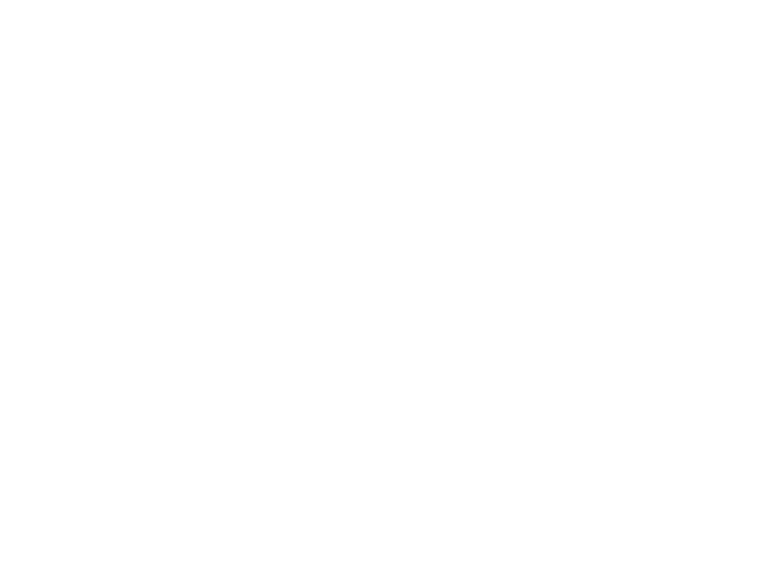

<IPython.core.display.Javascript object>


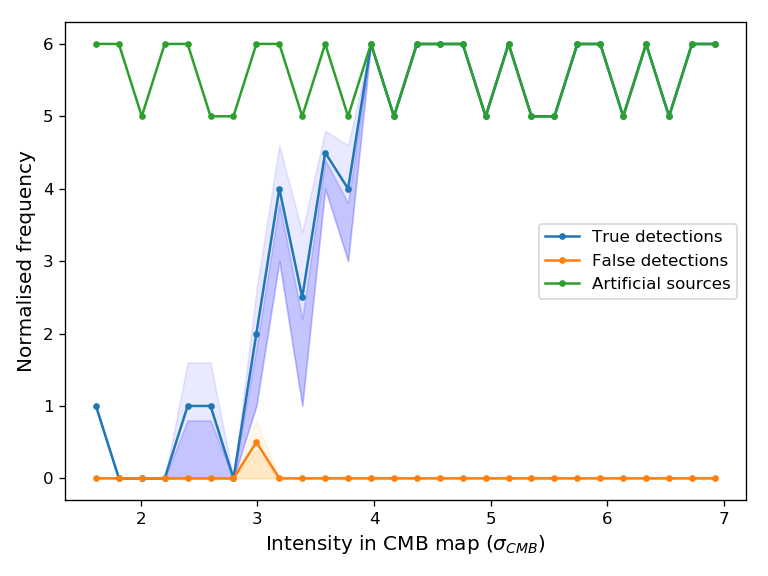

<IPython.core.display.Javascript object>


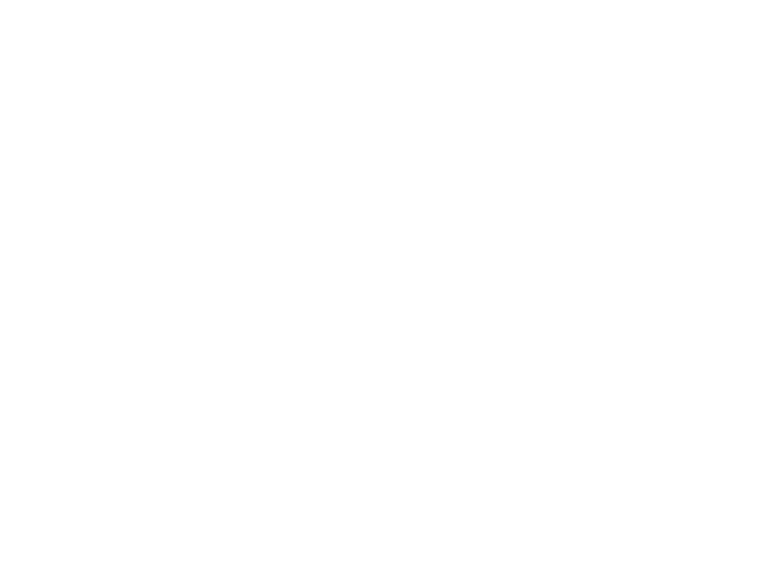

<IPython.core.display.Javascript object>


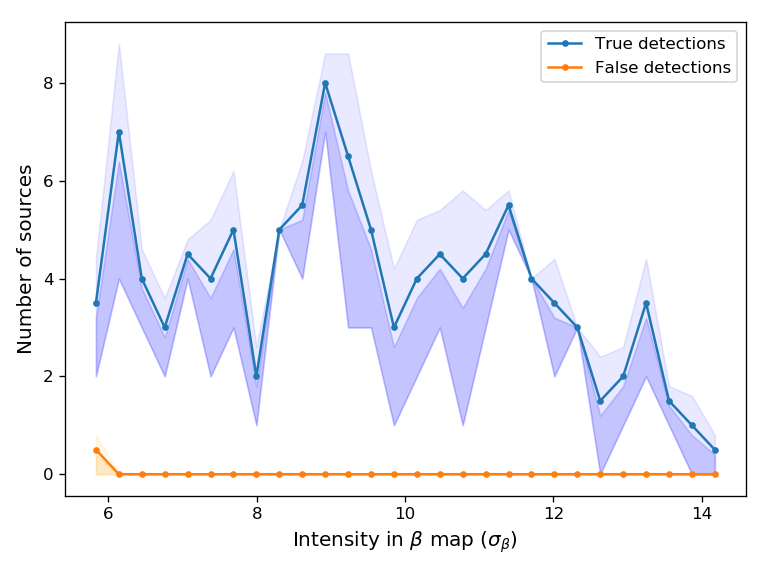

In [23]:
plt.figure()
numb,binsb,patchesb=plt.hist((detectintenpost+falsedetmap)/cmbsigma_smooth,bins=28)
inj,_,_=plt.hist(souintenpost/cmbsigma_smooth,bins=binsb)
cbinsb=(binsb[:-1]+binsb[1:])/2

truesb=np.mean(numb[:nmaps],axis=0)
falsesb=np.mean(numb[nmaps:],axis=0)
totb=truesb+falsesb
norma=np.ones(len(inj))
plt.close()

fig=plt.figure()
plt.plot(cbinsb,truesb,'.-',label='True detections')
for perc in [0.7,0.9]:
    minmax4=percent(perc,cbinsb,numb[:nmaps])
    plt.fill_between(cbinsb, minmax4[0],minmax4[1], color='b', alpha=(2-perc*1.75)*0.2)
    

plt.plot(cbinsb,falsesb/norma,'.-',label='False detections')
for perc in [0.7,0.9]:
    minmax5=percent(perc,cbinsb,numb[nmaps:])
    plt.fill_between(cbinsb, minmax5[0],minmax5[1], color='orange', alpha=(2-perc*1.75)*0.2)
    

plt.plot(cbinsb,inj,'.-',label='Artificial sources')
ax=plt.gca()
ax.set_xlabel('Intensity in CMB map ($\sigma_{CMB}$)',fontsize=12)
ax.set_ylabel('Normalised frequency',fontsize=12)

plt.legend()
plt.tight_layout()


plt.figure()
num,bins,patches=plt.hist(truebeta+falsebeta,bins=28)
cbins=(bins[:-1]+bins[1:])/2
plt.close()

trues=np.mean(num[:nmaps],axis=0)
falses=np.mean(num[nmaps:],axis=0)
tot=trues+falses


fig2=plt.figure()
plt.plot(cbins,trues,'.-',label='True detections')
for perc in [0.7,0.9]:
    minmax1=percent(perc,cbins,num[:nmaps])
    plt.fill_between(cbins, minmax1[0],minmax1[1], color='b', alpha=(2-perc*1.75)*0.2)
        
plt.plot(cbins,falses,'.-',label='False detections')
for perc in [0.7,0.9]:
    minmax2=percent(perc,cbins,num[nmaps:])
    plt.fill_between(cbins, minmax2[0],minmax2[1], color='orange', alpha=(2-perc*1.75)*0.2)
    
ax=plt.gca()
ax.set_xlabel(r'Intensity in $\beta$ map ($\sigma_{\beta}$)',fontsize=12)
ax.set_ylabel('Number of sources',fontsize=12)

plt.legend()
plt.tight_layout()



In [21]:
if usesources:
    hp.mollview(mapa+sources)

<IPython.core.display.Javascript object>

In [22]:
hp.mollview(betas.flatten()/sigmabeta[-1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


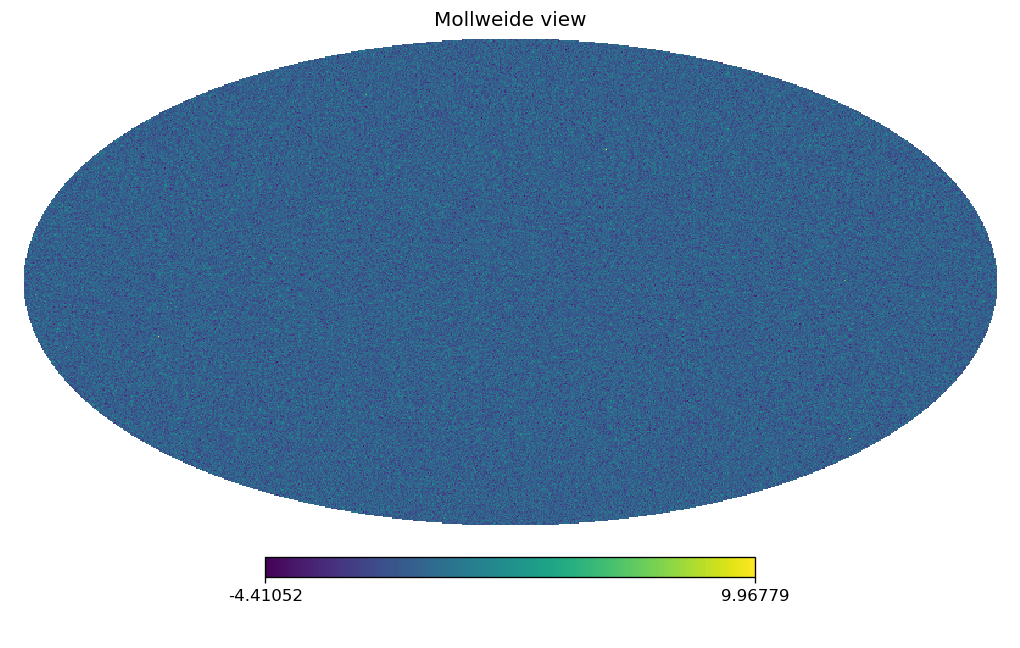

In [30]:
if usesources:
    #betasnhdu=fits.open(folder+'/'+str(nmaps-1)+'_needlet_coefficients_B'+str(f'{B:.2f}')+'_Nj'+Nj+'.fits')
    betasnhdu=fits.open(folder+'/beta'+str(nmaps-1)+'.fits')
    betasndata=betasnhdu[1].data
    betasn=betasndata[f'T_NEEDC_{j}']
    betasnhdu.close()
    hp.mollview(betasn.flatten()/sigmabeta[-1])

Generating gnome projected maps for ipix: 47518475
The intensity of this signal is 1382.6006996021983
The source has been detected in 0 out of 2 maps.
In particular, the source has not been detected in the map shown.


<IPython.core.display.Javascript object>


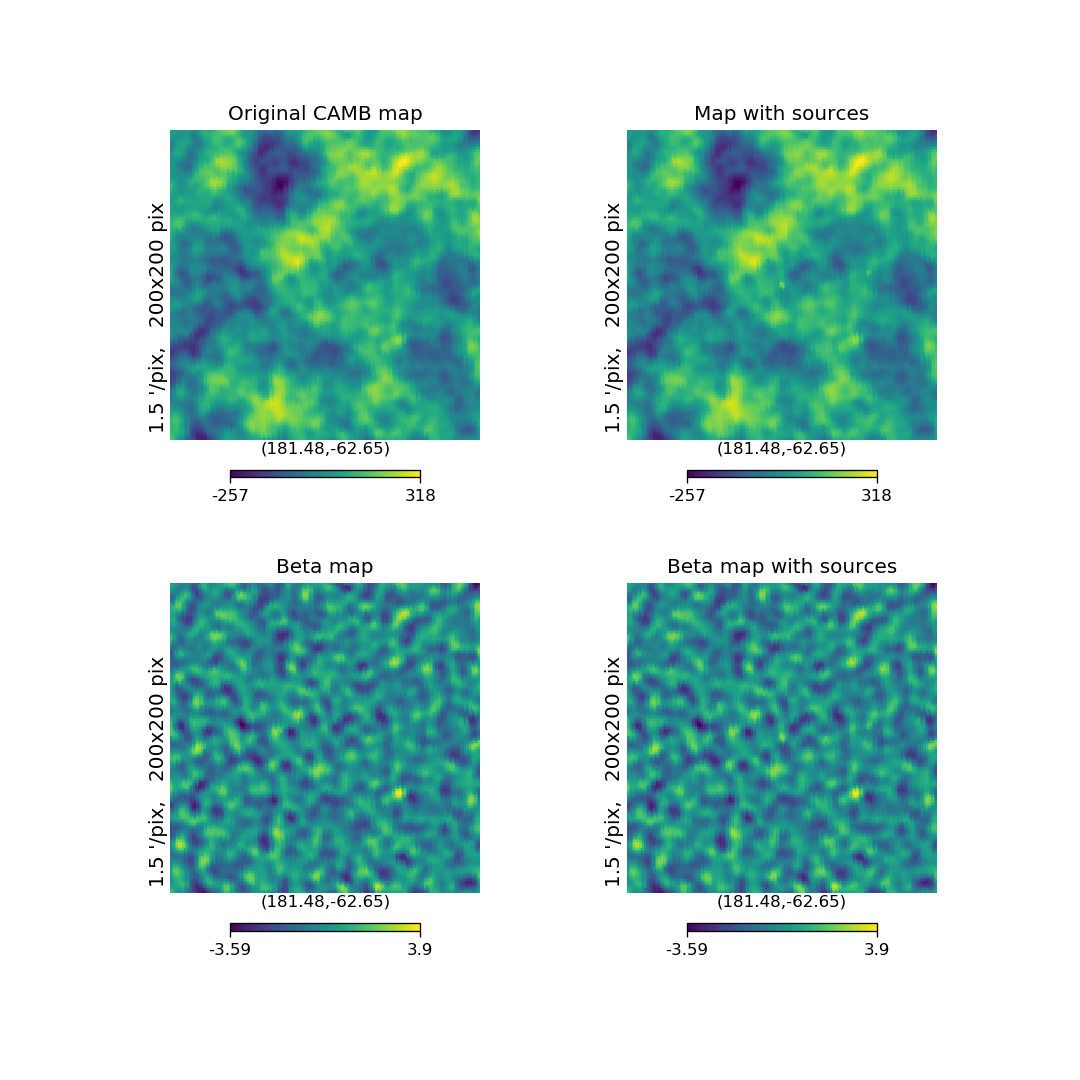

Generating gnome projected maps for ipix: 28622819
The intensity of this signal is 4395.961198735195
The source has been detected in 2 out of 2 maps.
In particular, the source has been detected in the map shown.


<IPython.core.display.Javascript object>


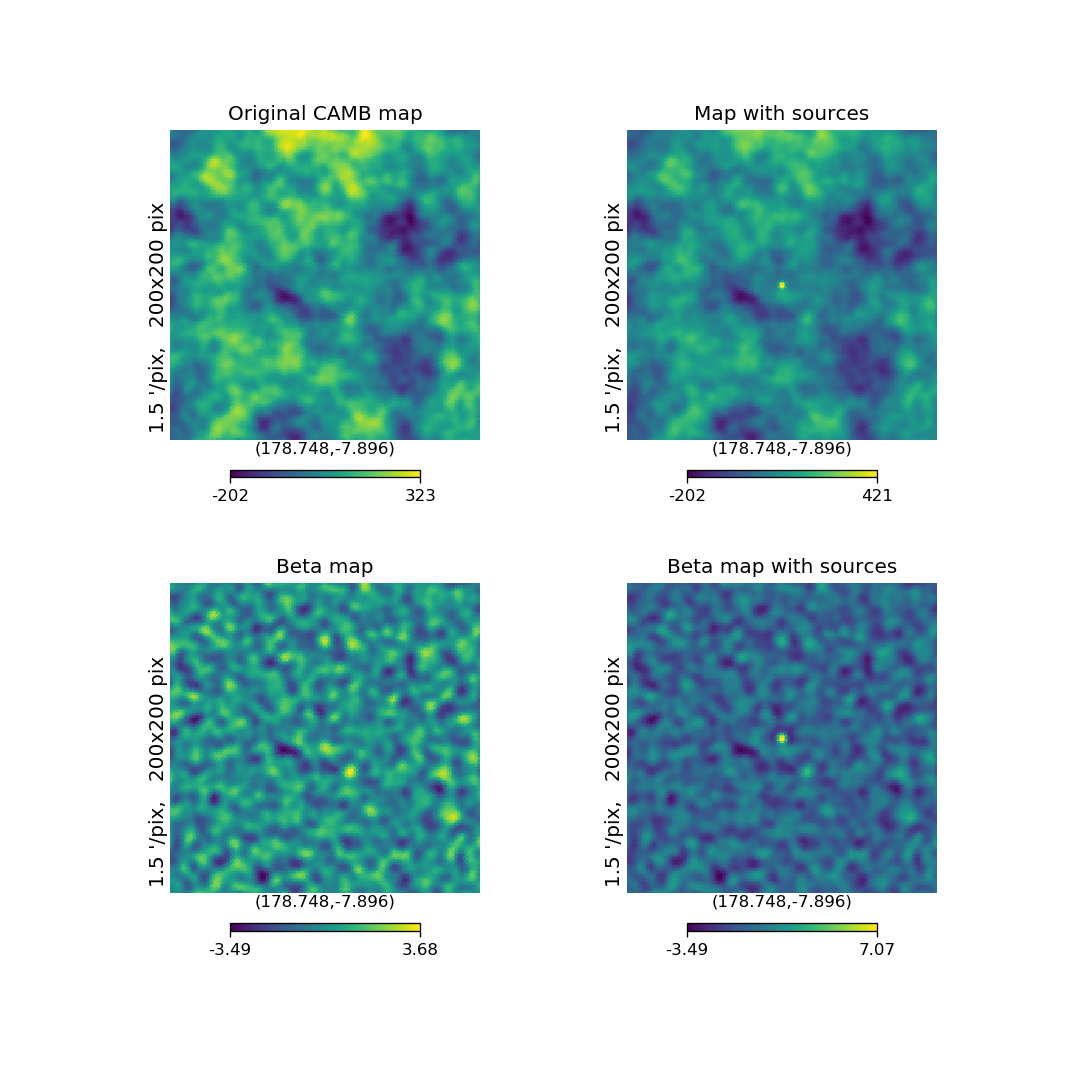

Generating gnome projected maps for ipix: 4478533
The intensity of this signal is 460.8668998673994
The source has been detected in 0 out of 2 maps.
In particular, the source has not been detected in the map shown.


<IPython.core.display.Javascript object>


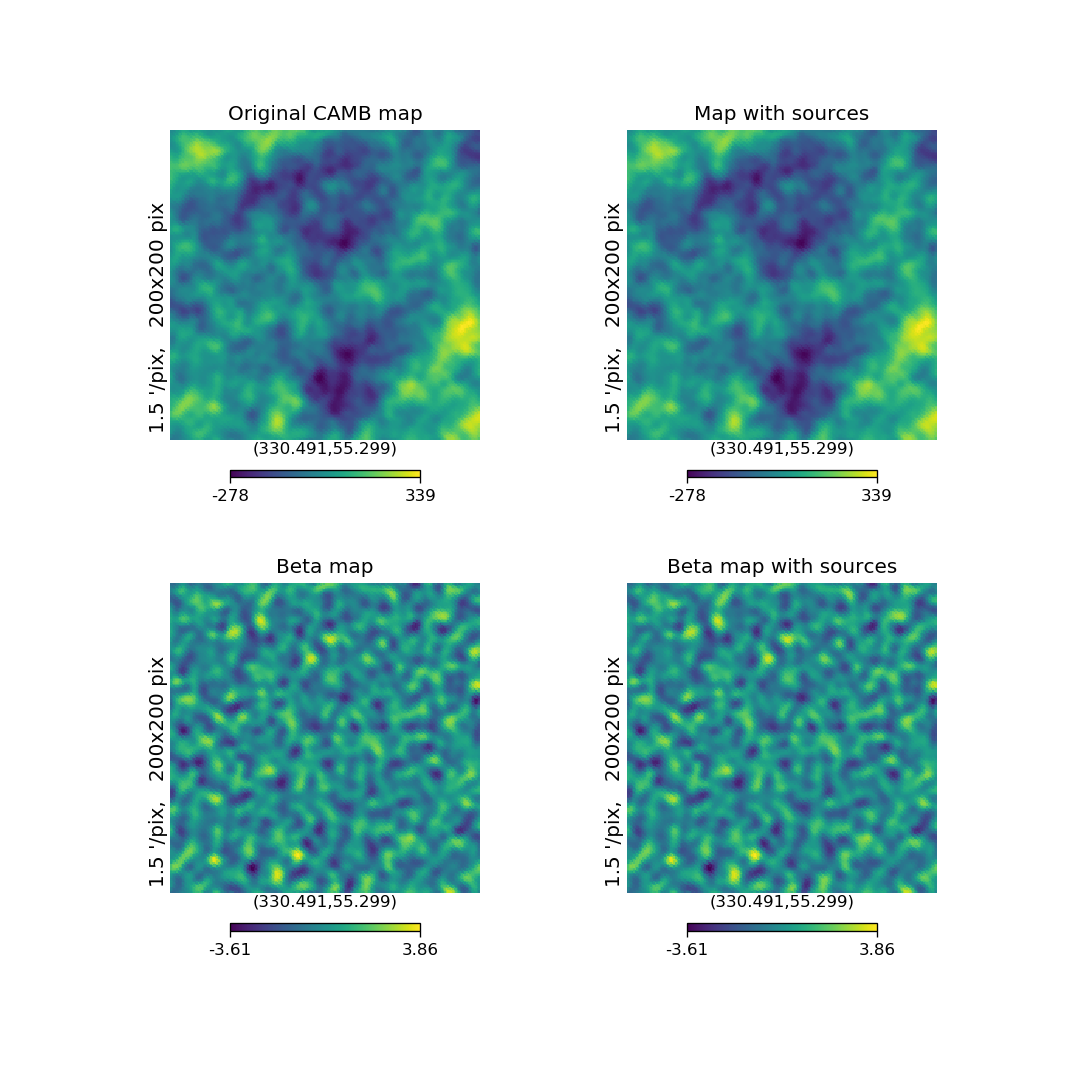

In [41]:
if usesources:
    size=200
    for i in np.random.randint(0,nsources,size=min([3,nsources])):
        dmap=0
        print('Generating gnome projected maps for ipix:',pixsou[i])
#         print(f'The intensity of this signal is {souinten[i]}')
        for imap in np.arange(nmaps):
            dmap=dmap+(i in detect[imap])
        print(f'The source has been detected in {dmap} out of {nmaps} maps.')
        if np.any(i in detect[-1]):
            print(f'In particular, the source has been detected in the map shown.')
        else:
            print(f'In particular, the source has not been detected in the map shown.')
        tt,pp=hp.pix2ang(nsidebeta,pixsou[i])
        fig,([ax1,ax2],[ax3,ax4])=plt.subplots(ncols=2,nrows=2,figsize=(9,9))
        plt.sca(ax1)
        hp.gnomview(mapa,rot=np.rad2deg([pp,np.pi/2-tt,0]),xsize=size,ysize=size,hold=True,title="Original CAMB map")
        plt.sca(ax2)
        hp.gnomview(mapa+sources,rot=np.rad2deg([pp,np.pi/2-tt,0]),xsize=size,ysize=size,hold=True,title='Map with sources')
        plt.sca(ax3)
        hp.gnomview(betas.flatten()/sigmabeta[-1],rot=np.rad2deg([pp,np.pi/2-tt,0]),xsize=size,ysize=size,hold=True,title="Beta map")
        plt.sca(ax4)
        hp.gnomview(betasn.flatten()/sigmabeta[-1],rot=np.rad2deg([pp,np.pi/2-tt,0]),xsize=size,ysize=size,hold=True,title='Beta map with sources')
